# Analysis of experiment 1

So our goal in Experiment 1 is to assign metadata to each clone with the following information:

1.  Clone Size (number of cells)
2.  Clone Cell type (CD4 or CD8)
3.  Clone Gene expression (Genes that identify this clone well – clonal gene signature)
4.  IL2RA expression level
5.  IL7R expression level

Some of this has already been done during preprocessing.


# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
import anndata
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

/opt/miniconda3/envs/clonalomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

In [3]:
ad = {}
samples = ['Sample{}'.format(j) for j in [1,2,3,4,5,6]]
cd_types = ['CD4','CD8']
datasets = [(sample, cd_type) for sample in samples for cd_type in cd_types]
for sample in samples:
    for cd_type in cd_types:
        filename = 'Processed/JM_10X_exp1_'+sample+'_'+cd_type+'.loom'
        ad[(sample,cd_type)] = sc.read_loom(filename) 
for cd_type in cd_types:
    filename = 'Processed/JM_10X_exp1_'+cd_type+'.loom'
    ad[cd_type] = sc.read_loom(filename) 

In [4]:
ad[('Sample1','CD4')]

AnnData object with n_obs × n_vars = 840 × 16012
    obs: 'CD_type', 'clone', 'clone_ID', 'experiment', 'hash_ID', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'nCount_CH', 'nCount_RNA', 'nFeature_CH', 'nFeature_RNA', 'n_genes_by_counts', 'orig_ident', 'pct_counts_mt', 'percent_mt', 'total_counts', 'total_counts_mt', 'well'
    var: 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'variances', 'variances_norm'

In [5]:
ad['CD4']

AnnData object with n_obs × n_vars = 8428 × 21621
    obs: 'CD_type', 'clone', 'clone_ID', 'experiment', 'hash_ID', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'nCount_CH', 'nCount_RNA', 'nFeature_CH', 'nFeature_RNA', 'n_genes_by_counts', 'orig_ident', 'pct_counts_mt', 'percent_mt', 'total_counts', 'total_counts_mt', 'well'
    var: 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'variances', 'variances_norm'

# Clone populations

In [6]:
clonepops = pd.DataFrame(index = ['Clone_{}'.format(j) for j in range(1,10)], 
                        columns=[ds[0]+'_'+ds[1] for ds in datasets])
for ds in datasets:
    col = ds[0]+'_'+ds[1]
    vc = ad[ds].obs.clone.value_counts()
    for j in range(len(vc)):
        clonepops.loc['Clone_{}'.format(j+1), col] = vc.iloc[j]

clonepops

Sample1_CD4 Sample1_CD8 Sample2_CD4 Sample2_CD8 Sample3_CD4  \
Clone_1         477         269        1180         263         988   
Clone_2         222         NaN         309         NaN         357   
Clone_3          82         NaN         100         NaN         174   
Clone_4          57         NaN           7         NaN         NaN   
Clone_5           2         NaN           1         NaN         NaN   
Clone_6         NaN         NaN         NaN         NaN         NaN   
Clone_7         NaN         NaN         NaN         NaN         NaN   
Clone_8         NaN         NaN         NaN         NaN         NaN   
Clone_9         NaN         NaN         NaN         NaN         NaN   

        Sample3_CD8 Sample4_CD4 Sample4_CD8 Sample5_CD4 Sample5_CD8  \
Clone_1         145         542         536        1527         269   
Clone_2          36         482         NaN          11          55   
Clone_3          10         241         NaN         NaN           5   
Clone_4         NaN         127         NaN         NaN         NaN   
Clone_5         NaN          75         NaN         NaN         NaN   
Clone_6         NaN         NaN         NaN         NaN         NaN   
Clone_7         NaN         NaN         NaN         NaN         NaN   
Clone_8         NaN         NaN         NaN         NaN         NaN   
Clone_9         NaN         NaN         NaN         NaN         NaN   

        Sample6_CD4 Sample6_CD8  
Clone_1         908         220  
Clone_2         520          74  
Clone_3          39         NaN  
Clone_4         NaN         NaN  
Clone_5         NaN         NaN  
Clone_6         NaN         NaN  
Clone_7         NaN         NaN  
Clone_8         NaN         NaN  
Clone_9         NaN         NaN

In [7]:
clonepops.to_csv('exp1_clonepops.csv')

# Clonal gene analysis

## Filtering data

Here we filter our datasets to keep only clones with at least 50 cells, and keeping only genes which are expressed by at least 5% of (remaining) cells.  

In [9]:
for ds in datasets:
    vc = ad[ds].obs.clone.value_counts()
    bigclones = vc[vc >= 50].index
    goodcells = ad[ds].obs[ad[ds].obs.clone.isin(bigclones)].index
    print('Filtering {} cells down to {} cells'.format(len(ad[ds].obs), len(goodcells)))
    ad[ds] = ad[ds][goodcells]

Filtering 838 cells down to 838 cells
Filtering 269 cells down to 269 cells
Filtering 1589 cells down to 1589 cells
Filtering 263 cells down to 263 cells
Filtering 1519 cells down to 1519 cells
Filtering 191 cells down to 145 cells
Filtering 1467 cells down to 1467 cells
Filtering 536 cells down to 536 cells
Filtering 1538 cells down to 1527 cells
Filtering 324 cells down to 324 cells
Filtering 1467 cells down to 1428 cells
Filtering 294 cells down to 294 cells


In [10]:
for ds in datasets:
    X = ad[ds].to_df()
    dropout = ((X == 0.0).sum() / len(X))
    goodgenes = dropout[dropout <= 0.95].index
    print('Filtering {} genes down to {} genes'.format(len(ad[ds].var), len(goodgenes)))
    ad[ds].var['dropout'] = dropout
    ad[ds] = ad[ds][:,goodgenes]

Filtering 16012 genes down to 8508 genes
Filtering 13971 genes down to 7951 genes
Filtering 17380 genes down to 8865 genes
Filtering 13733 genes down to 8565 genes


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout


Filtering 16945 genes down to 7800 genes
Filtering 13019 genes down to 8270 genes
Filtering 17237 genes down to 8201 genes
Filtering 14825 genes down to 8233 genes


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout


Filtering 16999 genes down to 9182 genes
Filtering 13899 genes down to 8783 genes
Filtering 17865 genes down to 8337 genes
Filtering 13788 genes down to 8248 genes


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/59375914.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[ds].var['dropout'] = dropout


## Clonal gene analysis

We find clonal genes, adjusting p-values by Bonferroni as well as a custom dropout-based multiplier.  (p-value gets adjusted by multiplying by 1/(1-dropout), so a gene with 95% dropout gets p-value multiplied by 1/0.05 = 20.)  This works well enough, empirically, to adjust for the fact that dropout increases frequency of low p-values by chance alone.  We perform a permutation test to estimate false discoveries in the end.

In [11]:
nperm = 100

for ds in datasets:
    X = ad[ds].to_df()
    y = ad[ds].obs.clone
    # Make a dataframe of shuffled clone labels.
    yshuff_df = pd.DataFrame(index = y.index, columns=range(nperm))
    yshuff_df = pd.concat([y.astype(str) for j in range(nperm)], axis=1) # Concat nperm copies of y.
    ys_vals = yshuff_df.values
    [np.random.shuffle(x) for x in ys_vals.T]
    yshuff_df.columns = ['Shuffle_{}'.format(j) for j in range(nperm)]
    for col in yshuff_df.columns:
        ad[ds].obs[col] = yshuff_df[col]
    print('Created {} permuted clone labels for dataset {}'.format(nperm, ds))

/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff

Created 100 permuted clone labels for dataset ('Sample1', 'CD4')
Created 100 permuted clone labels for dataset ('Sample1', 'CD8')
Created 100 permuted clone labels for dataset ('Sample2', 'CD4')
Created 100 permuted clone labels for dataset ('Sample2', 'CD8')
Created 100 permuted clone labels for dataset ('Sample3', 'CD4')
Created 100 permuted clone labels for dataset ('Sample3', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff

Created 100 permuted clone labels for dataset ('Sample4', 'CD4')
Created 100 permuted clone labels for dataset ('Sample4', 'CD8')
Created 100 permuted clone labels for dataset ('Sample5', 'CD4')
Created 100 permuted clone labels for dataset ('Sample5', 'CD8')
Created 100 permuted clone labels for dataset ('Sample6', 'CD4')
Created 100 permuted clone labels for dataset ('Sample6', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].obs[col] = yshuff_df[col]
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/1406422706.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

In [12]:
datasets_cl = []
for ds in datasets:
    X = ad[ds].to_df()
    y = ad[ds].obs.clone
    if len(np.unique(y)) > 1:
        F_pvals = ss.f_oneway(*[X[y == k] for k in np.unique(y)])[1]
        ad[ds].var['F_pval'] = F_pvals
        for j in range(nperm):
            ys = ad[ds].obs['Shuffle_{}'.format(j)]
            F_pvals = ss.f_oneway(*[X[ys == k] for k in np.unique(ys)])[1]
            ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
        print('Computed p-values for {} permuted clone labels for dataset {}'.format(nperm, ds))
        datasets_cl.append(ds)
    else:
        print('{} has only one clone'.format(ds))
    

/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample1', 'CD4')
('Sample1', 'CD8') has only one clone


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample2', 'CD4')
('Sample2', 'CD8') has only one clone


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample3', 'CD4')
('Sample3', 'CD8') has only one clone


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample4', 'CD4')
('Sample4', 'CD8') has only one clone
('Sample5', 'CD4') has only one clone


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample5', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Computed p-values for 100 permuted clone labels for dataset ('Sample6', 'CD4')
Computed p-values for 100 permuted clone labels for dataset ('Sample6', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['F_pval_Shuffle_{}'.format(j)] = F_pvals
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/692960352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [13]:
for ds in datasets_cl:
    for col in ['F_pval'] + ['F_pval_Shuffle_{}'.format(j) for j in range(nperm)]:
        Fp = ad[ds].var[col]
        Ap = Fp / (1 - ad[ds].var['dropout']) # Custom dropout-based adjustment
        Ap = Ap * len(Ap) # Bonferonni adjustment
        Ap = np.minimum(Ap,1.0)
        ad[ds].var['Adj_'+col] = Ap
    print('Adjusted p-values for {}'.format(ds))

/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

Adjusted p-values for ('Sample1', 'CD4')
Adjusted p-values for ('Sample2', 'CD4')
Adjusted p-values for ('Sample3', 'CD4')
Adjusted p-values for ('Sample4', 'CD4')
Adjusted p-values for ('Sample5', 'CD8')
Adjusted p-values for ('Sample6', 'CD4')
Adjusted p-values for ('Sample6', 'CD8')


/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ad[ds].var['Adj_'+col] = Ap
/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/239725030.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

In [14]:
sig_genes = {}
for i,ds in enumerate(datasets_cl):
    sg = (ad[ds].var['Adj_F_pval'].sort_values() < 0.05)
    sig_genes[ds] = sg[sg].index
    sh_cols = ['Adj_F_pval_Shuffle_{}'.format(j) for j in range(nperm)]
    sg_df = (ad[ds].var[sh_cols] < 0.05)
    FDs = sg_df.sum().mean()
    print('{} clonal genes found in {}, with {} expected by chance.'.format(len(sig_genes[ds]), ds, FDs))

323 clonal genes found in ('Sample1', 'CD4'), with 0.05 expected by chance.
285 clonal genes found in ('Sample2', 'CD4'), with 0.08 expected by chance.
386 clonal genes found in ('Sample3', 'CD4'), with 0.01 expected by chance.
517 clonal genes found in ('Sample4', 'CD4'), with 0.02 expected by chance.
33 clonal genes found in ('Sample5', 'CD8'), with 0.05 expected by chance.
479 clonal genes found in ('Sample6', 'CD4'), with 0.02 expected by chance.
49 clonal genes found in ('Sample6', 'CD8'), with 0.02 expected by chance.


In [15]:
sig_gene_df = pd.DataFrame(columns = datasets_cl, index=['Gene_{}'.format(j) for j in range(1,600)])
for ds in datasets_cl:
    for j,gene in enumerate(sig_genes[ds]):
        sig_gene_df[ds].loc['Gene_{}'.format(j+1)] = gene
display(sig_gene_df)

(Sample1, CD4) (Sample2, CD4) (Sample3, CD4) (Sample4, CD4)  \
Gene_1            ARMH1           CCL5          NOSIP           TCF7   
Gene_2             CCR7           NKG7           IL7R          PLAC8   
Gene_3           MT-CO3         PECAM1          SP140         SPINT2   
Gene_4             NCF4           BEX3           LEF1            CD7   
Gene_5           IFITM2          ENPP3          CXCR6           LEF1   
...                 ...            ...            ...            ...   
Gene_595            NaN            NaN            NaN            NaN   
Gene_596            NaN            NaN            NaN            NaN   
Gene_597            NaN            NaN            NaN            NaN   
Gene_598            NaN            NaN            NaN            NaN   
Gene_599            NaN            NaN            NaN            NaN   

         (Sample5, CD8) (Sample6, CD4) (Sample6, CD8)  
Gene_1              MAL          GSTM2          KLRC1  
Gene_2          TRG-AS1            CD7           XCL1  
Gene_3             CD44           CCL5          AHNAK  
Gene_4             LAG3         IFITM2          RAMP1  
Gene_5            LITAF         PLAAT3           CD8B  
...                 ...            ...            ...  
Gene_595            NaN            NaN            NaN  
Gene_596            NaN            NaN            NaN  
Gene_597            NaN            NaN            NaN  
Gene_598            NaN            NaN            NaN  
Gene_599            NaN            NaN            NaN  

[599 rows x 7 columns]

In [16]:
sig_gene_df.to_csv('exp1_clonalgenes.csv')

In [17]:
ad[ds].var

highly_variable  highly_variable_rank  log1p_mean_counts  \
Gene                                                                   
NOC2L                     0                   NaN           0.149102   
ISG15                     0                   NaN           0.237994   
C1orf159                  0                   NaN           0.031319   
TNFRSF18                  1                 191.0           0.248779   
TNFRSF4                   1                 110.0           0.469574   
...                     ...                   ...                ...   
MT-ND4                    0                   NaN           1.633480   
MT-ND5                    0                   NaN           1.782690   
MT-ND6                    1                 962.0           0.748955   
MT-CYB                    0                   NaN           2.857127   
AL592183.1                0                   NaN           0.109436   

            log1p_total_counts  mean_counts      means  mt  n_cells_by_counts  \
Gene                                                                            
NOC2L                 5.926926     0.160791   0.160791   0                350   
ISG15                 6.439351     0.268702   0.268702   0                527   
C1orf159              4.317488     0.031814   0.031814   0                 74   
TNFRSF18              6.489205     0.282459   0.282459   0                461   
TNFRSF4               7.240650     0.599312   0.599312   0                830   
...                        ...          ...        ...  ..                ...   
MT-ND4                9.168267     4.121668   4.121668   1               2212   
MT-ND5                9.350537     4.945830   4.945830   1               2217   
MT-ND6                7.860956     1.114789   1.114789   1               1360   
MT-CYB               10.549910    16.411436  16.411436   1               2325   
AL592183.1            5.598422     0.115649   0.115649   0                235   

              n_counts  pct_dropout_by_counts  ...  Adj_F_pval_Shuffle_90  \
Gene                                           ...                          
NOC2L        47.676212              84.952709  ...                    1.0   
ISG15        90.869904              77.343078  ...                    1.0   
C1orf159     22.857210              96.818573  ...                    1.0   
TNFRSF18     68.260010              80.180567  ...                    1.0   
TNFRSF4      47.539009              64.316423  ...                    1.0   
...                ...                    ...  ...                    ...   
MT-ND4      576.556946               4.901118  ...                    1.0   
MT-ND5      585.819763               4.686156  ...                    1.0   
MT-ND6      205.390244              41.530525  ...                    1.0   
MT-CYB      948.093201               0.042992  ...                    1.0   
AL592183.1   38.451862              89.896819  ...                    1.0   

            Adj_F_pval_Shuffle_91  Adj_F_pval_Shuffle_92  \
Gene                                                       
NOC2L                         1.0                    1.0   
ISG15                         1.0                    1.0   
C1orf159                      1.0                    1.0   
TNFRSF18                      1.0                    1.0   
TNFRSF4                       1.0                    1.0   
...                           ...                    ...   
MT-ND4                        1.0                    1.0   
MT-ND5                        1.0                    1.0   
MT-ND6                        1.0                    1.0   
MT-CYB                        1.0                    1.0   
AL592183.1                    1.0                    1.0   

            Adj_F_pval_Shuffle_93  Adj_F_pval_Shuffle_94  \
Gene                                                       
NOC2L                         1.0                    1.0   
ISG15                         1.0                    1.0  

In [18]:
for ds in datasets_cl:
    gene_df = ad[ds].var[['dropout','highly_variable','F_pval','Adj_F_pval']].sort_values(by='Adj_F_pval')
    gene_df.to_csv('exp1_'+ds[0]+'_'+ds[1]+'_genelist.csv')

# Well differences.

Now that we've found clone-specific genes within each well (sample), we look for well-specific differences.

In [19]:
ad['CD4'].obs['well'].value_counts()

Sample2    1597
Sample5    1538
Sample3    1519
Sample4    1467
Sample6    1467
Sample1     840
Name: well, dtype: int64

Here we compute dropout rates for each gene (all samples together), and run analysis of well-to-well variance.

In [20]:
for cd in cd_types:
    X = ad[cd].to_df()
    dropout = ((X == 0.0).sum() / len(X))
    ad[cd].var['dropout'] = dropout
    y = ad[cd].obs.well
    if len(np.unique(y)) > 1:
        Fp = ss.f_oneway(*[X[y == k] for k in np.unique(y)])[1]
        ad[cd].var['F_pval_well'] = Fp
        Ap = Fp / (1 - ad[cd].var['dropout']) # Custom dropout-based adjustment
        Ap = Ap * len(Ap) # Bonferonni adjustment
        Ap = np.minimum(Ap,1.0)
        ad[cd].var['adj_F_pval_well'] = Ap

In [21]:
ad[cd].var.sort_values(by='F_pval_well')

highly_variable  highly_variable_rank  log1p_mean_counts  \
Gene                                                                   
KRT1                      1                 135.0           0.239652   
ITM2A                     1                 743.0           0.991051   
AOAH                      1                 553.0           0.970203   
IL4R                      1                 484.0           0.803914   
IL7R                      1                 161.0           1.542566   
...                     ...                   ...                ...   
CHMP3                     0                   NaN           0.261686   
AL020995.1                0                   NaN           0.010909   
RCN1                      0                   NaN           0.089275   
IFFO1                     0                   NaN           0.055498   
EIF1AD                    0                   NaN           0.067346   

            log1p_total_counts  mean_counts     means  mt  n_cells_by_counts  \
Gene                                                                           
KRT1                  8.203852     0.270807  0.270807   0               1641   
ITM2A                10.037100     1.694064  1.694064   0               8902   
AOAH                 10.003740     1.638479  1.638479   0               8050   
IL4R                  9.720466     1.234270  1.234270   0               6938   
IL7R                 10.811928     3.676573  3.676573   0               8419   
...                        ...          ...       ...  ..                ...   
CHMP3                 8.303257     0.299118  0.299118   0               3332   
AL020995.1            5.003946     0.010969  0.010969   0                147   
RCN1                  7.139660     0.093382  0.093382   0               1177   
IFFO1                 6.647688     0.057067  0.057067   0                746   
EIF1AD                6.846943     0.069666  0.069666   0                892   

               n_counts  pct_dropout_by_counts  total_counts  variances  \
Gene                                                                      
KRT1         446.698212              87.838138        3654.0   0.890044   
ITM2A       1679.410522              34.025050       22858.0   4.583834   
AOAH        2416.046143              40.339435       22108.0   4.776497   
IL4R        1525.255127              48.580746       16654.0   3.367216   
IL7R         962.840576              37.604684       49608.0  26.410952   
...                 ...                    ...           ...        ...   
CHMP3        498.902008              75.305714        4036.0   0.336997   
AL020995.1    26.429478              98.910546         148.0   0.010997   
RCN1         160.811111              91.276958        1260.0   0.097564   
IFFO1        115.020279              94.471207         770.0   0.057520   
EIF1AD       120.568687              93.389165         940.0   0.072377   

            variances_norm   dropout    F_pval_well  adj_F_pval_well  
Gene                                                                  
KRT1              2.768804  0.863443  4.883417e-128    6.409095e-123  
ITM2A             1.402652  0.447396  4.403579e-117    1.428166e-112  
AOAH              1.532412  0.317216  2.277767e-109    5.978776e-105  
IL4R              1.603418  0.485654   1.161652e-90     4.047686e-86  
IL7R              2.569030  0.690223   2.840810e-90     1.643538e-85  
...                    ...       ...            ...              ...  
CHMP3             0.938260  0.783209   9.987358e-01     1.000000e+00  
AL020995.1        0.924383  0.987779   9.988789e-01     1.000000e+00  
RCN1              0.931977  0.924548   9.989531e-01     1.000000e+00  
IFFO1             0.903473  0.947928   9.989819e-01     1.000000e+00  
EIF1AD            0.929412  0.943677   9.999744e-01     1.000000e+00  

[17922 rows x 16 columns]

In [22]:
clonepops

Sample1_CD4 Sample1_CD8 Sample2_CD4 Sample2_CD8 Sample3_CD4  \
Clone_1         477         269        1180         263         988   
Clone_2         222         NaN         309         NaN         357   
Clone_3          82         NaN         100         NaN         174   
Clone_4          57         NaN           7         NaN         NaN   
Clone_5           2         NaN           1         NaN         NaN   
Clone_6         NaN         NaN         NaN         NaN         NaN   
Clone_7         NaN         NaN         NaN         NaN         NaN   
Clone_8         NaN         NaN         NaN         NaN         NaN   
Clone_9         NaN         NaN         NaN         NaN         NaN   

        Sample3_CD8 Sample4_CD4 Sample4_CD8 Sample5_CD4 Sample5_CD8  \
Clone_1         145         542         536        1527         269   
Clone_2          36         482         NaN          11          55   
Clone_3          10         241         NaN         NaN           5   
Clone_4         NaN         127         NaN         NaN         NaN   
Clone_5         NaN          75         NaN         NaN         NaN   
Clone_6         NaN         NaN         NaN         NaN         NaN   
Clone_7         NaN         NaN         NaN         NaN         NaN   
Clone_8         NaN         NaN         NaN         NaN         NaN   
Clone_9         NaN         NaN         NaN         NaN         NaN   

        Sample6_CD4 Sample6_CD8  
Clone_1         908         220  
Clone_2         520          74  
Clone_3          39         NaN  
Clone_4         NaN         NaN  
Clone_5         NaN         NaN  
Clone_6         NaN         NaN  
Clone_7         NaN         NaN  
Clone_8         NaN         NaN  
Clone_9         NaN         NaN

In [98]:
well_genes = {}
for cd in cd_types:
    Ap = ad[cd].var['adj_F_pval_well']
    well_genes[cd] = Ap[Ap < 1e-300].sort_values().index
    print('{} well genes found in {}'.format(len(well_genes[cd]), cd))
    Ap.sort_values().to_csv('well_genes_adj_pvals_{}.csv'.format(cd))

153 well genes found in CD4
0 well genes found in CD8


In [99]:
ad['CD8']

AnnData object with n_obs × n_vars = 1882 × 17922
    obs: 'CD_type', 'clone', 'clone_ID', 'experiment', 'hash_ID', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'nCount_CH', 'nCount_RNA', 'nFeature_CH', 'nFeature_RNA', 'n_genes_by_counts', 'orig_ident', 'pct_counts_mt', 'percent_mt', 'total_counts', 'total_counts_mt', 'well'
    var: 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'variances', 'variances_norm', 'dropout', 'F_pval_well', 'adj_F_pval_well'

In [100]:
wg_marks = {}
for cd in cd_types:
    wg_marks[cd] = ad[cd].to_df()[well_genes[cd]].groupby(ad[cd].obs.well).mean().idxmax().sort_values()
    

/var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/ipykernel_67562/133842101.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wg_marks[cd] = ad[cd].to_df()[well_genes[cd]].groupby(ad[cd].obs.well).mean().idxmax().sort_values()


In [101]:
wg_marks['CD4'].value_counts()

Sample5    67
Sample3    41
Sample4    16
Sample6    13
Sample1    12
Sample2     4
dtype: int64

In [102]:
samples

['Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6']

In [103]:
wg_topmarks = {}
for cd in cd_types:
    wgm = wg_marks[cd]
    wg_topmarks[cd] = []
    for well in samples:
        wg_topmarks[cd] += list(wgm[wgm == well][:4].index)
    display(wgm.loc[wg_topmarks[cd]])

Gene
RPS3        Sample1
RPS18       Sample1
RPL8        Sample1
RPL5        Sample1
GIMAP4      Sample2
RAB34       Sample2
CD52        Sample2
FOS         Sample2
RPL13       Sample3
RPL35A      Sample3
HLA-B       Sample3
RPS23       Sample3
IFI44L      Sample4
GIMAP7      Sample4
GZMA        Sample4
PLAAT4      Sample4
CD74        Sample5
DBI         Sample5
UHRF1       Sample5
APOBEC3B    Sample5
RPL39       Sample6
GAS5        Sample6
RPL9        Sample6
RPL24       Sample6
dtype: object

Series([], dtype: float64)

In [104]:
bigclones = {}
for cd in cd_types:
    vc = ad[cd].obs.clone.value_counts()
    vc = vc[vc >= 50]
    bigclones[cd] = vc.index

In [105]:
wc = {}
clones = {}
ccuts = {}
for cd in cd_types:
    vc = ad[cd].obs[['well','clone']].value_counts()
    wc[cd] = vc[vc >= 50].sort_index().index
    clones[cd] = [mi[1] for mi in wc[cd]]
    ccuts[cd] = pd.Series([mi[0] for mi in wc[cd]]).value_counts().sort_index().cumsum()
    
    

In [106]:
bigclones['CD4']

Index(['5', '2', '3', '4', '7', '21', '11', '1', '12', '19', '10', '15', '24',
       '28', '9', '18', '8', '13'],
      dtype='object')

In [107]:
ad[cd].obs.clone.isin(bigclones[cd]).count()

1882

In [110]:
def mydot(cd, genelist=None):
    inbigs = ad[cd].obs.clone.isin(bigclones[cd])
    X_cells = inbigs[inbigs].index
    X = ad[cd].to_df().loc[X_cells]
    
    seps = []
    if genelist:
        genelist = genelist
    else:
        genelist = list(wg_topmarks[cd])
        seps.append(len(genelist))
        for sample in samples:
            ds = (sample, cd)
            if ds in sig_genes.keys():
                newgenes = sig_genes[ds][:10]
                oldnewgenes = [gene for gene in newgenes if gene in well_genes[cd][:20]]
                print('{} genes already found.',format(len(oldnewgenes)))
                X_t = ad[ds].to_df()[newgenes]
                y_t = ad[ds].obs.clone
                svs = X_t.groupby(y_t).mean().idxmax().sort_values()
                genelist = genelist + list(svs.index)
            #seps.append(len(genelist))
        
    genelist = [gene for gene in genelist if gene in X.columns]
    
    X = X[genelist].copy()
    y = ad[cd][X_cells].obs['clone']
    
    X_nzmean = (X.sum()) / ((X>0).sum())
    X_mins = X.min()
    X_maxs = X.max()
    X_ranges = X_maxs - X_mins
    
    hrule()
    
    clonal_nzmean = X.groupby(y).apply(lambda col : (col.sum()) / ((col > 0).sum()) )
    clonal_ons = X.groupby(y).apply(lambda col : (col>0).sum() / len(col))
    
    
    clonal_norm = ((clonal_nzmean - X_mins) / X_ranges) # min/max scaled nonzero means.
    
    plot_data = clonal_norm.melt(ignore_index = False)
    plot_data['clone'] = plot_data.index
    plot_data['clone'] = pd.Categorical(plot_data['clone'],
                                       categories=clones[cd],
                                       ordered=True)
    plot_data['mean_nz'] = plot_data['value']
    plot_data['on_ratio'] = clonal_ons.melt(ignore_index=False)['value']
    

    plot_data['clone'] = plot_data.index
    plot_data['clone'] = pd.Categorical(plot_data['clone'],
                                       categories=clones[cd],
                                       ordered=True)
    
    width=len(clones[cd]) / 2
    height = len(genelist) / 2.5
    fig,ax = plt.subplots(1,1,figsize=(width, height))
    sns.set_style('white')
    sns.scatterplot(x='clone', y='Gene', hue='mean_nz', size='on_ratio', sizes=(20,200), data=plot_data, ax=ax,
                   palette='inferno', vmin=0, vmax=1)

    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
    ax.set_xticks(clones[cd])
    for c in ccuts[cd][:-1]:
        ax.axvline(c - 0.5)
    for j,sep in enumerate(seps):
        ax.axhline(sep-0.5)
        if j == 0:
            ax.axhline(sep-0.5, c='red', lw=2)

    plt.suptitle('Gene expression among clones and wells:  {} {} cells'.format(len(X), cd), y=0.95)
    plt.show()

{} genes already found. 0
{} genes already found. 0
{} genes already found. 0
{} genes already found. 0
{} genes already found. 0


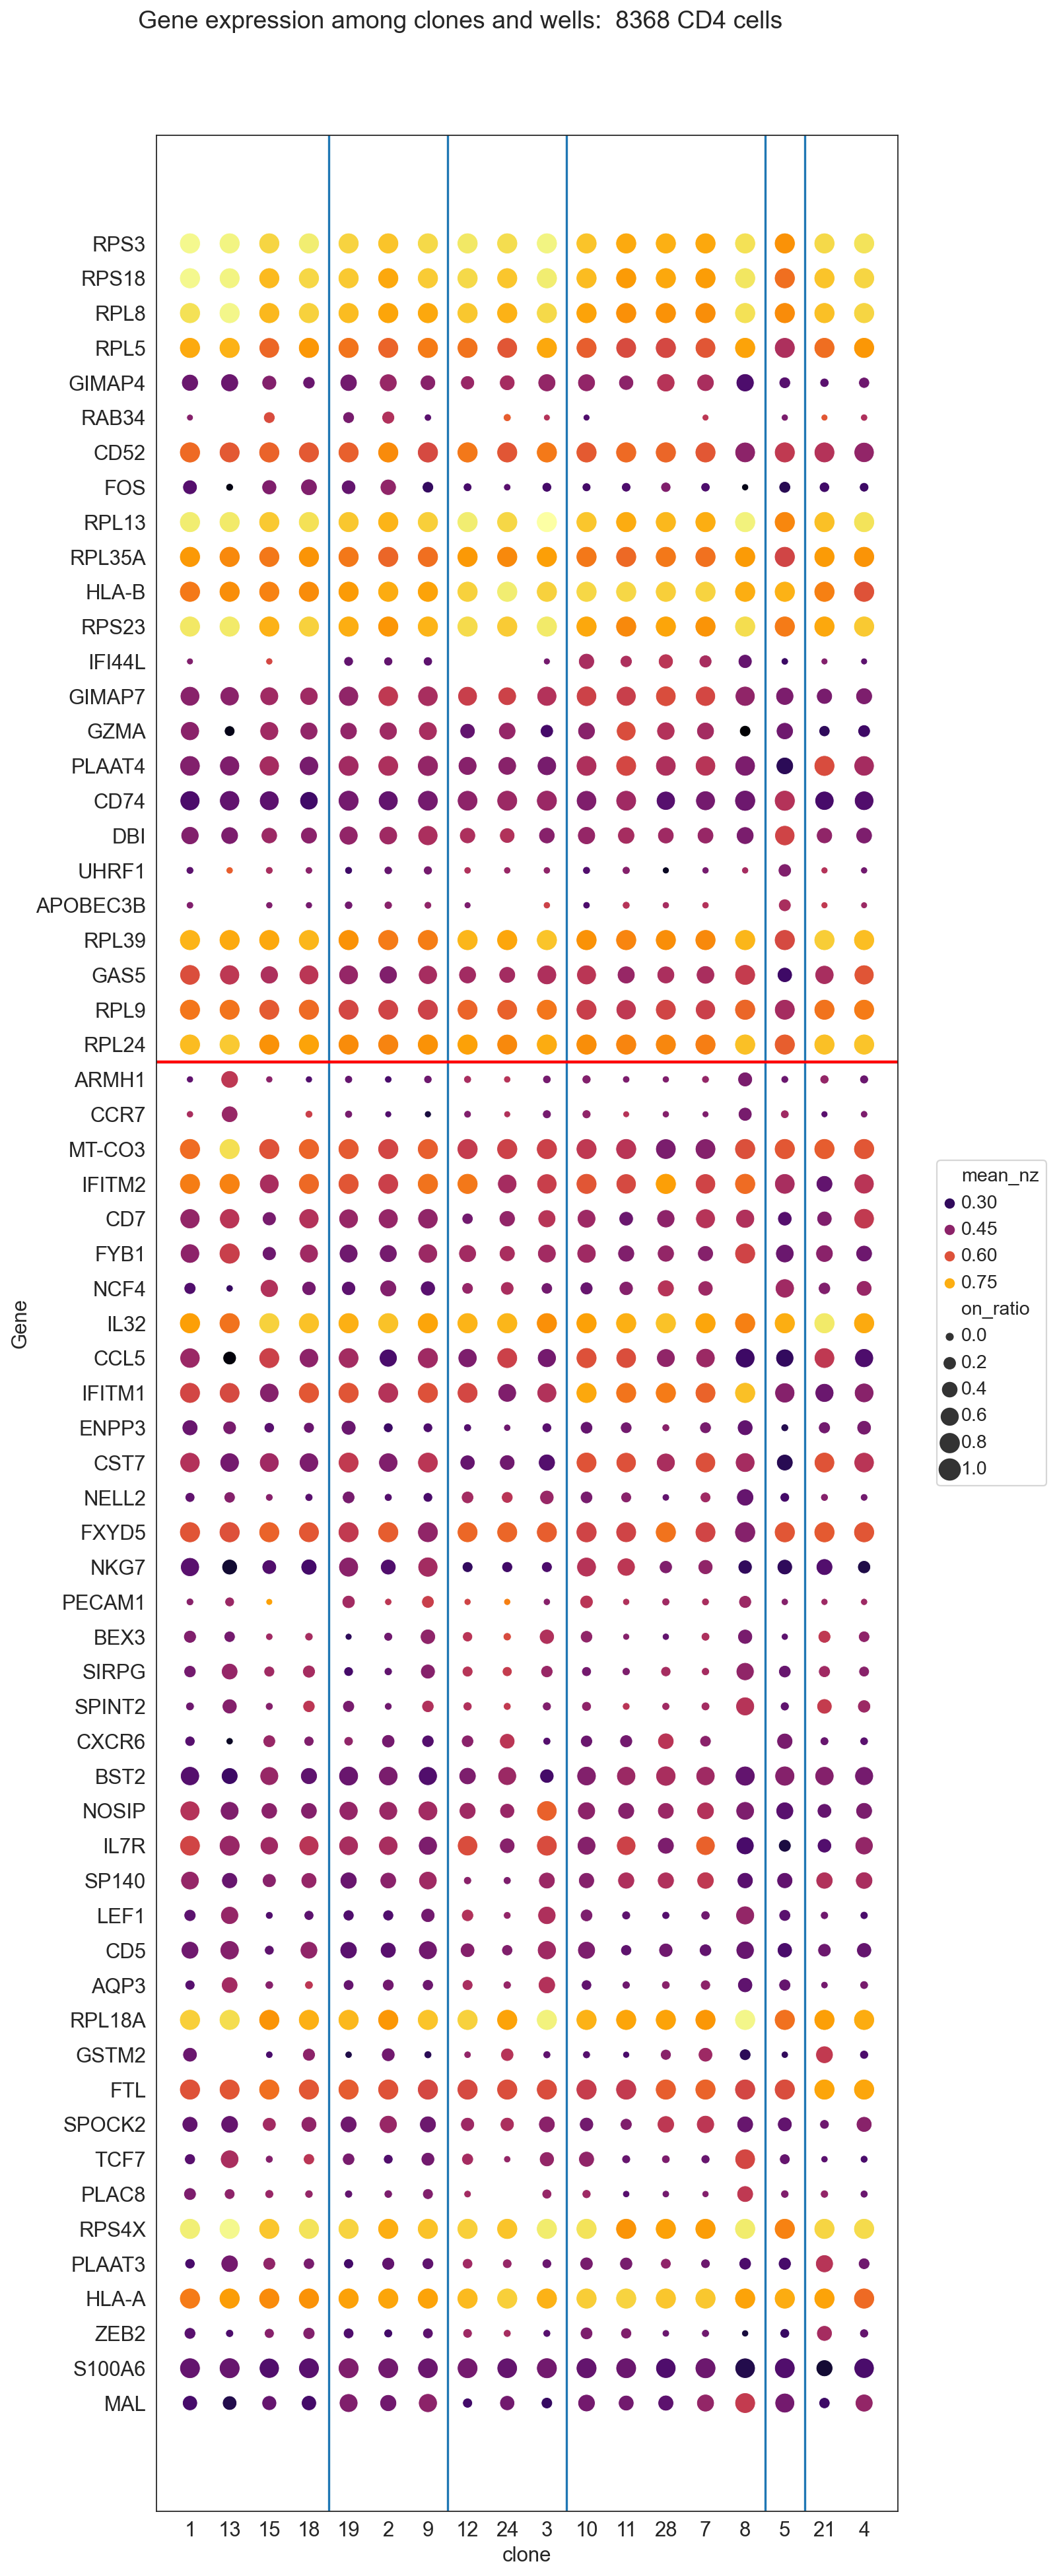

In [111]:
mydot('CD4')

In [114]:
# copypasta from genes Jeff sent.
jeffgenes = 'LEF1, TCF7, JUN, HOPX, GATA3, THEMIS, EOMES, RUNX1, ZEB1, ZEB2, KLF2, NKG7, CCL4, CCL5, IL4L1, CD5, CD6, CD7, CD44, IL2RA, IL4R, IL7R, IL9R, IL12RB2, CCR3, CXCR4, CXCR6, CCR7, GPR183, S1PR1, SELL'
jeffgenes = jeffgenes.split(', ')
print(jeffgenes)

['LEF1', 'TCF7', 'JUN', 'HOPX', 'GATA3', 'THEMIS', 'EOMES', 'RUNX1', 'ZEB1', 'ZEB2', 'KLF2', 'NKG7', 'CCL4', 'CCL5', 'IL4L1', 'CD5', 'CD6', 'CD7', 'CD44', 'IL2RA', 'IL4R', 'IL7R', 'IL9R', 'IL12RB2', 'CCR3', 'CXCR4', 'CXCR6', 'CCR7', 'GPR183', 'S1PR1', 'SELL']


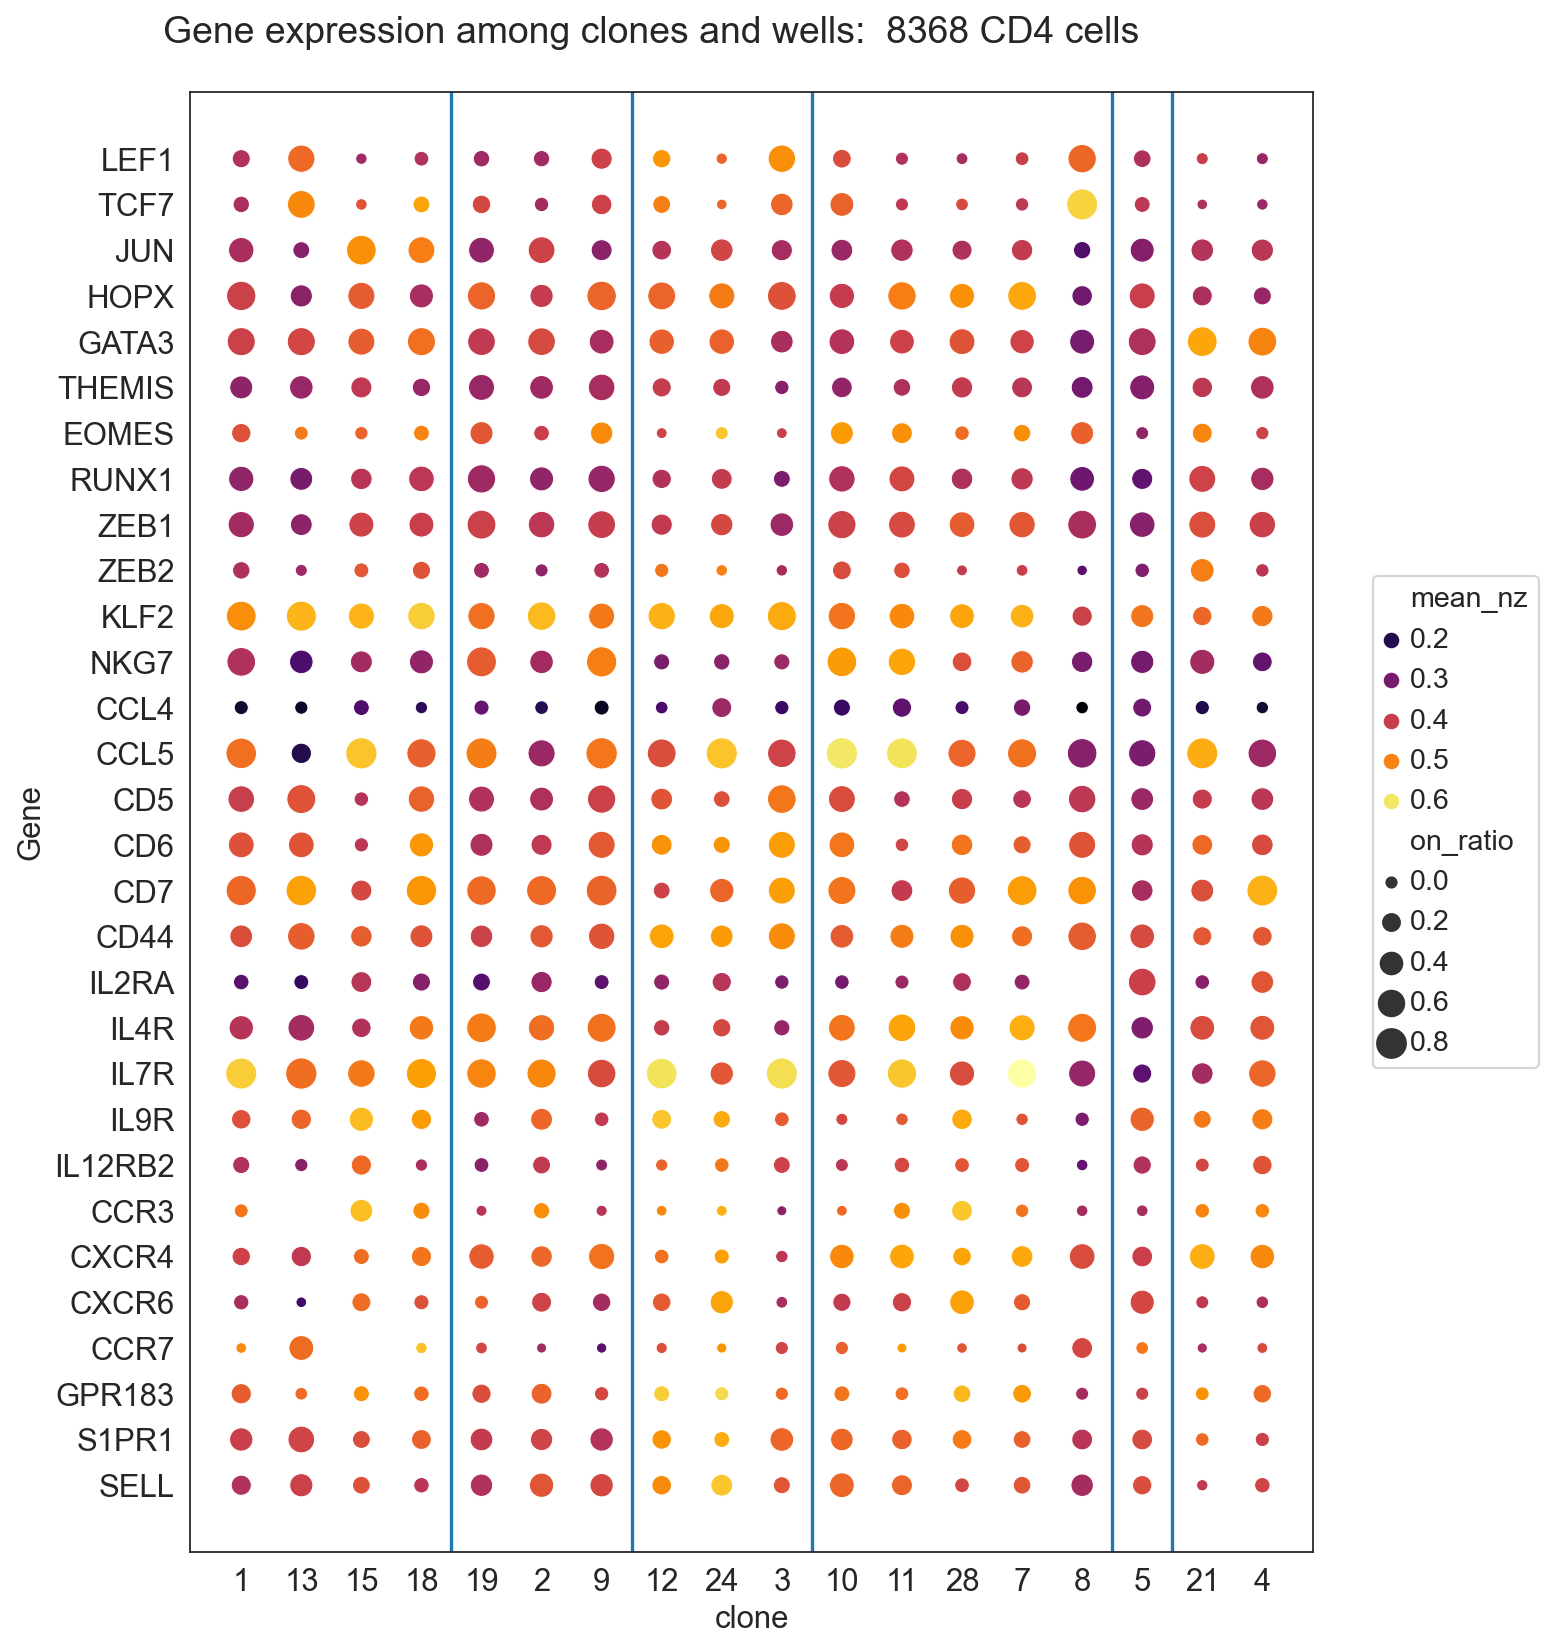

In [115]:
mydot('CD4', genelist = jeffgenes)

{} genes already found. 0
{} genes already found. 0


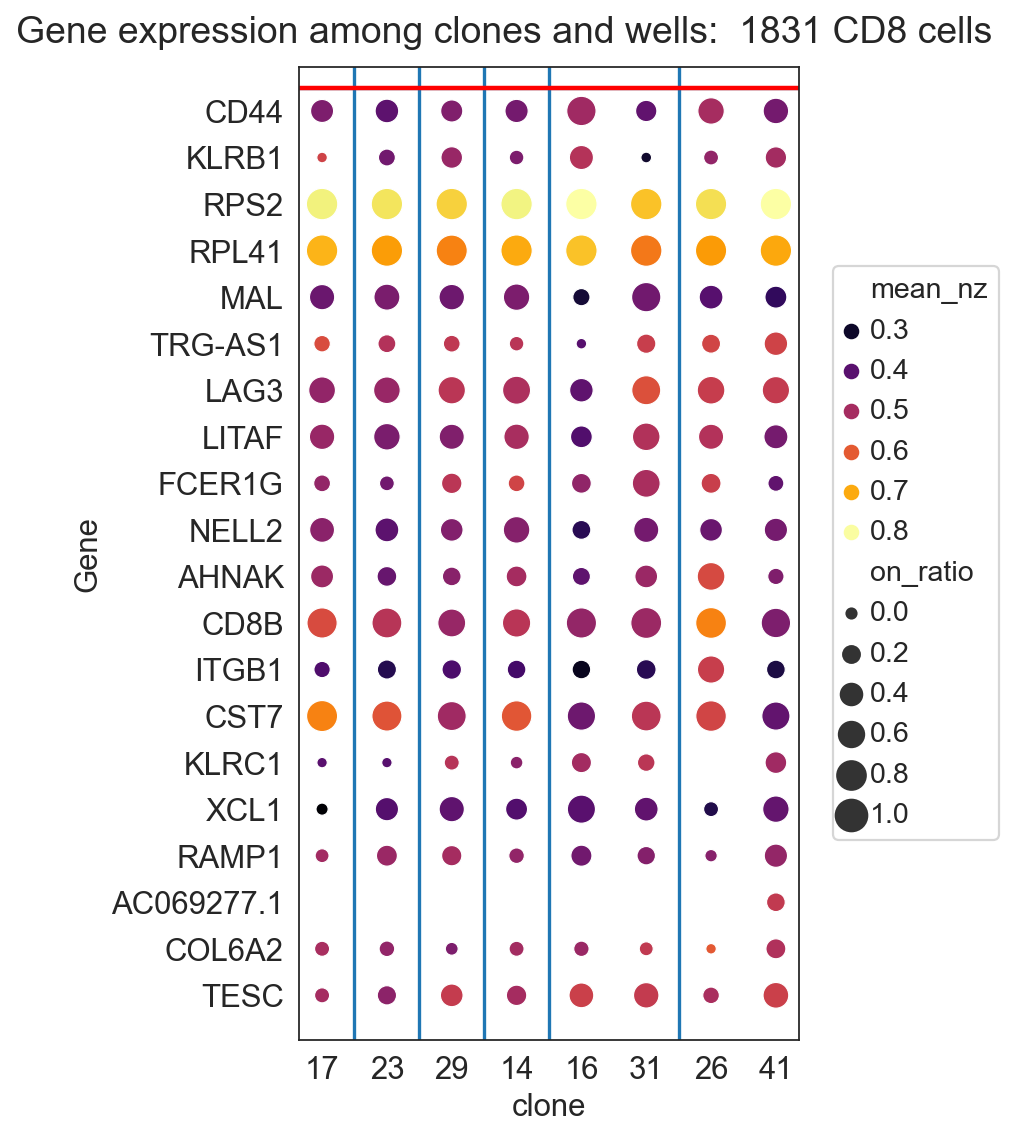

In [122]:
mydot('CD8')

In [124]:
def myvio(gene, cd):
    if gene not in ad[cd].var_names:
        return None
    ad_temp = ad[cd][:,[gene]].copy()
    ad_temp.obs = ad_temp.obs[['well','clone']]
    ad_temp.obs['clone'] = pd.Categorical(ad_temp.obs['clone'],
                                          categories=clones[cd],
                                          ordered=True)
    width = len(clones[cd]) * 0.5
    fig,ax = plt.subplots(1,1,figsize=(width,4))
    sc.pl.violin(ad_temp, gene, groupby='clone', ax=ax, show=False)
    for c in ccuts[cd][:-1]:
        ax.axvline(c - 0.5, lw=2)
    plt.show()
    

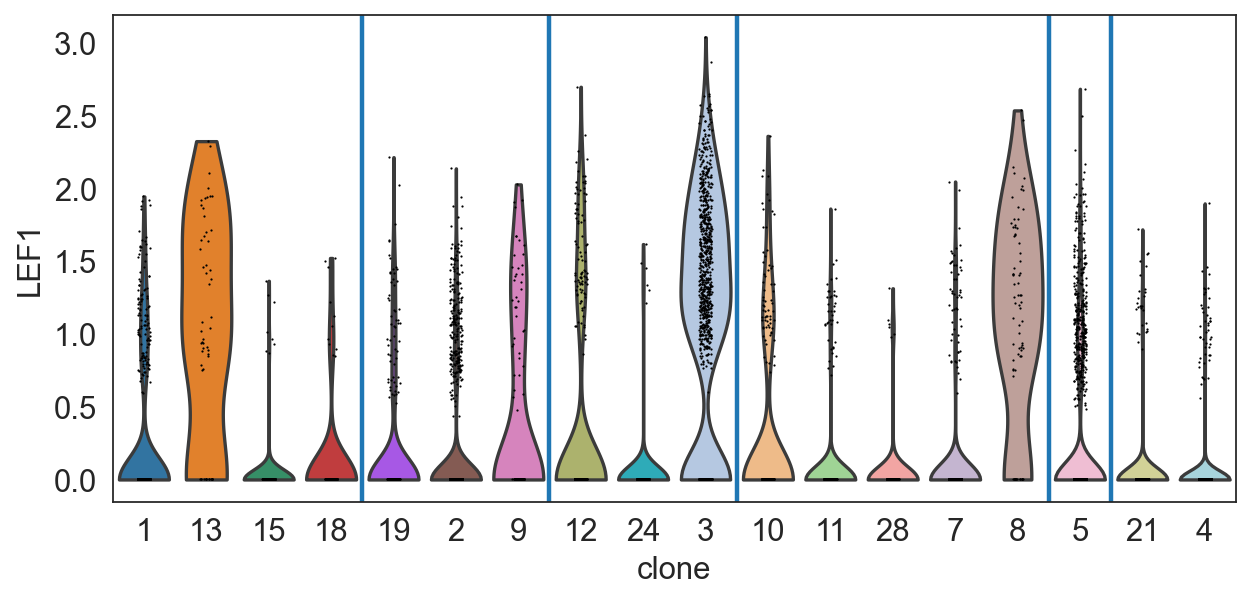

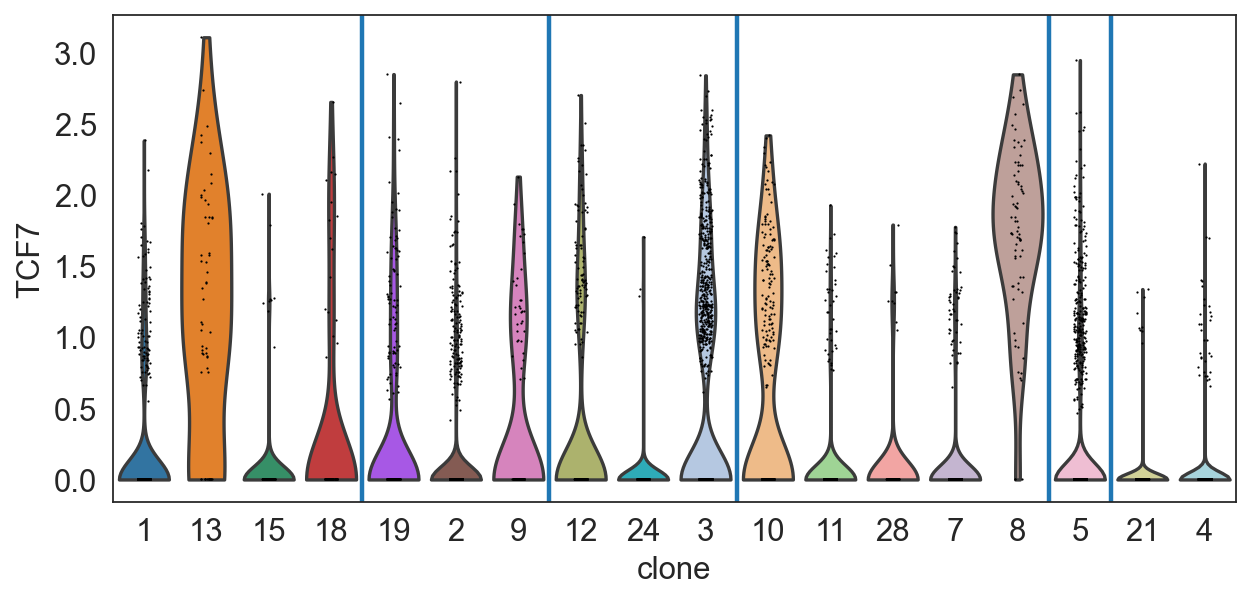

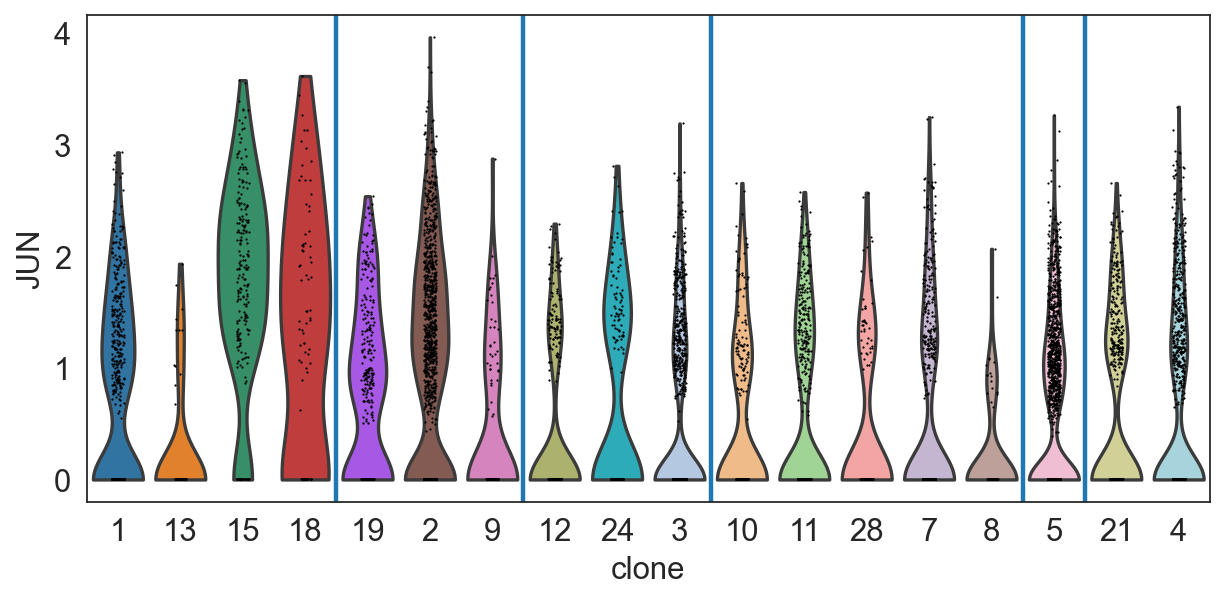

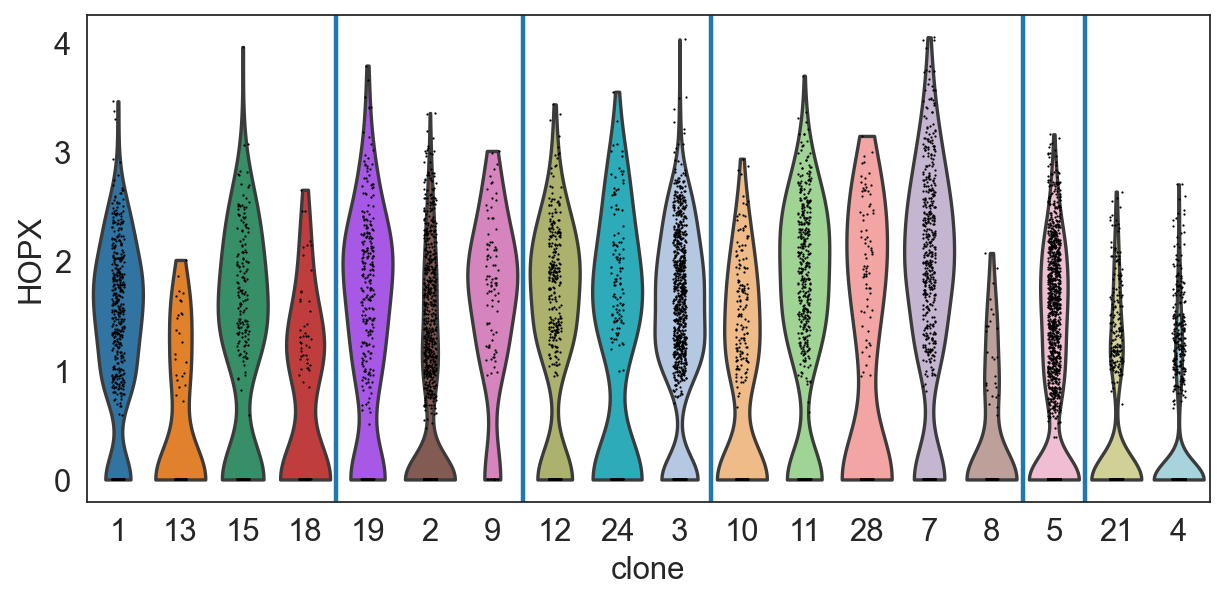

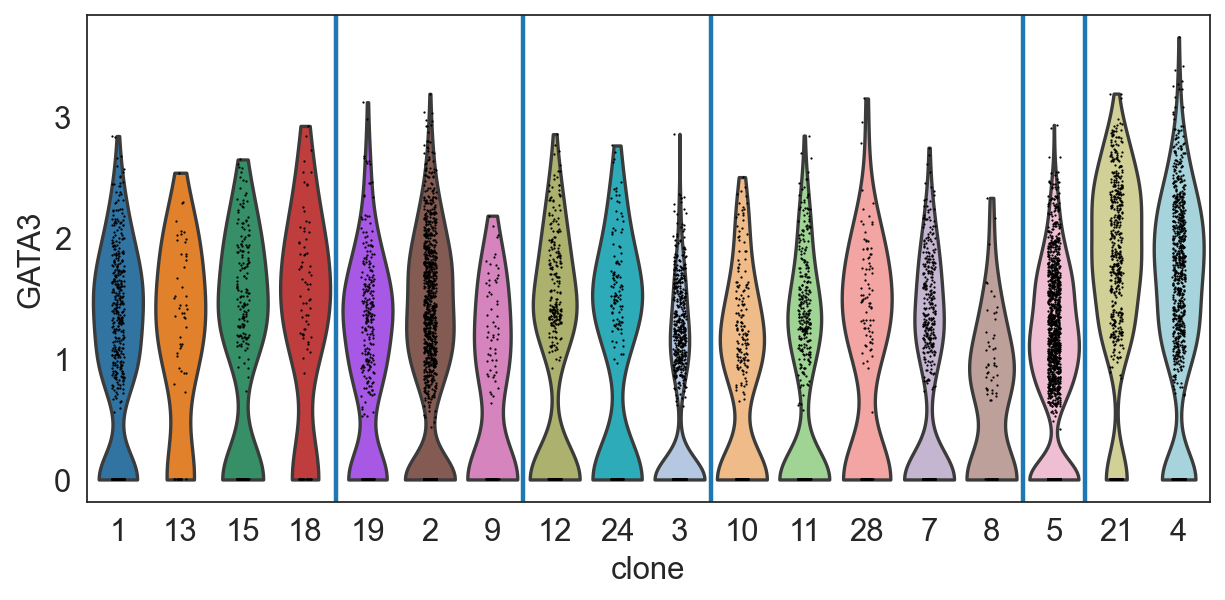

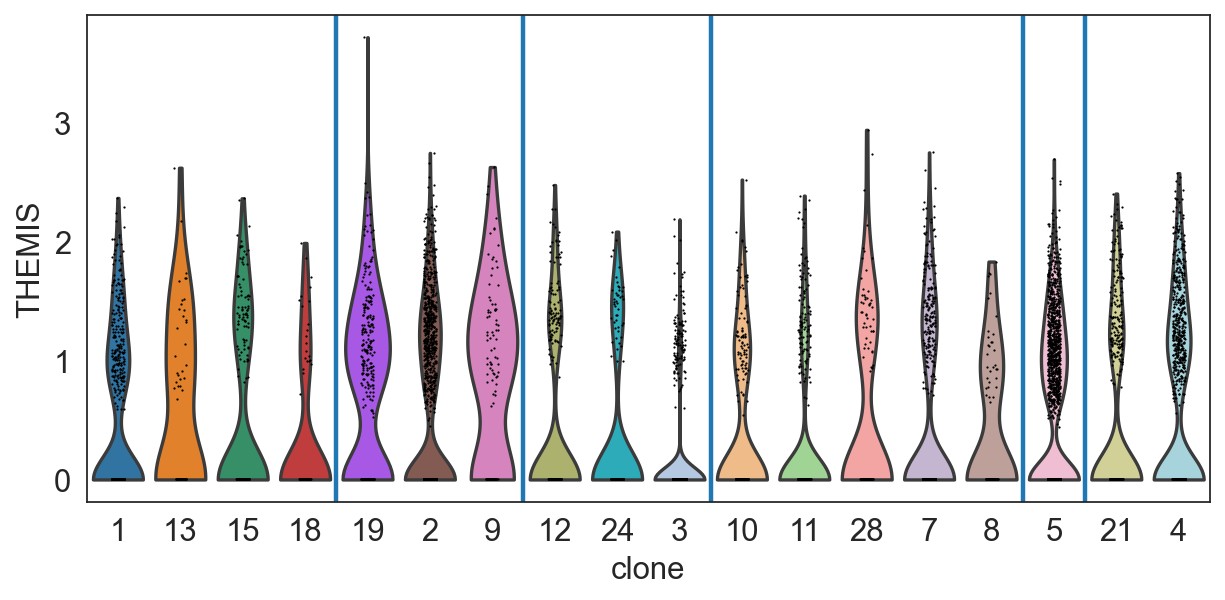

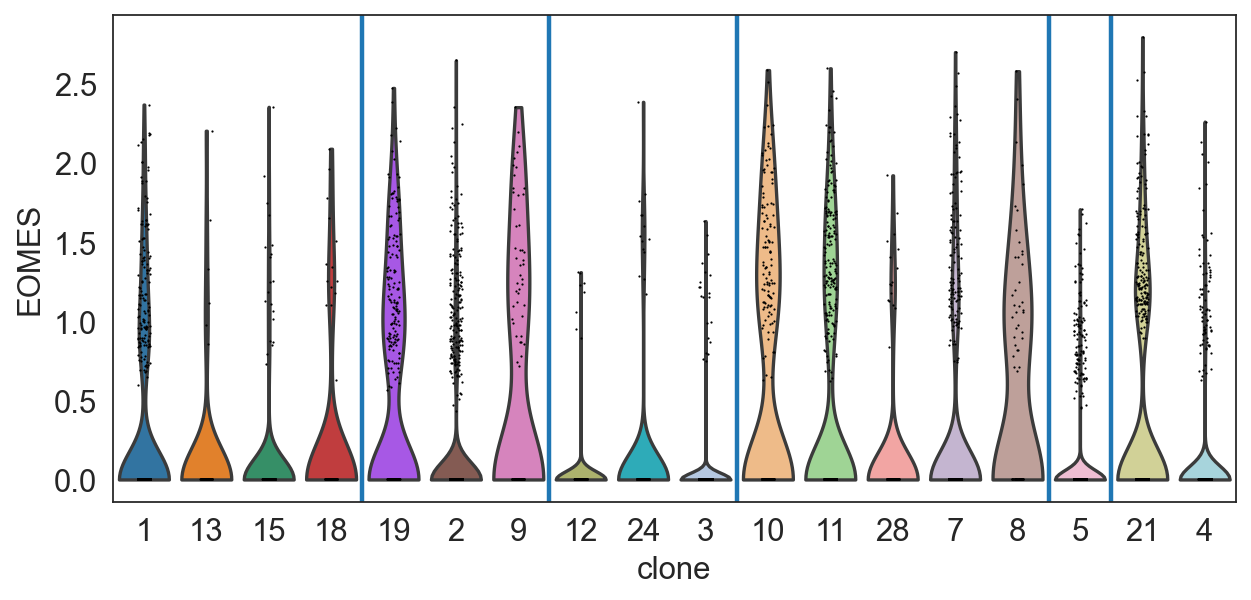

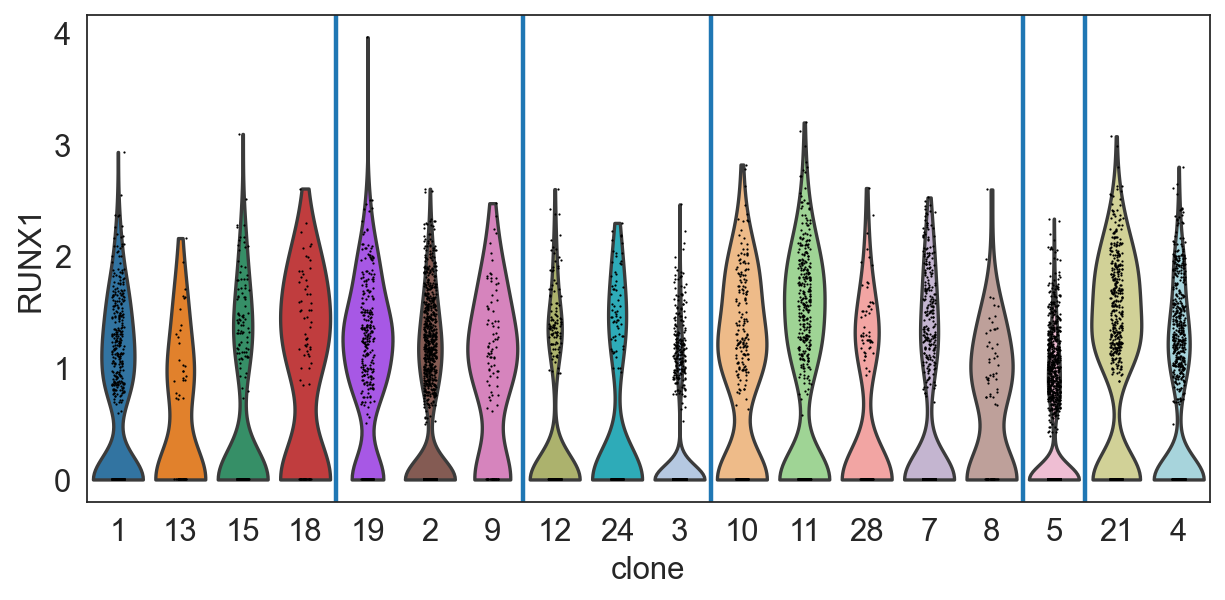

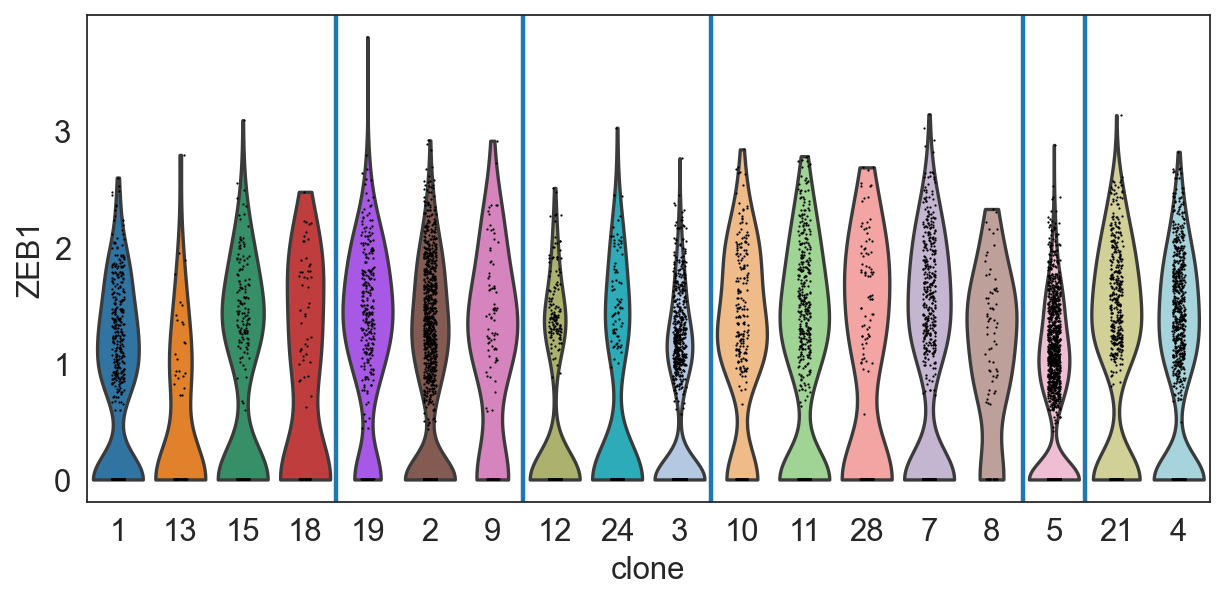

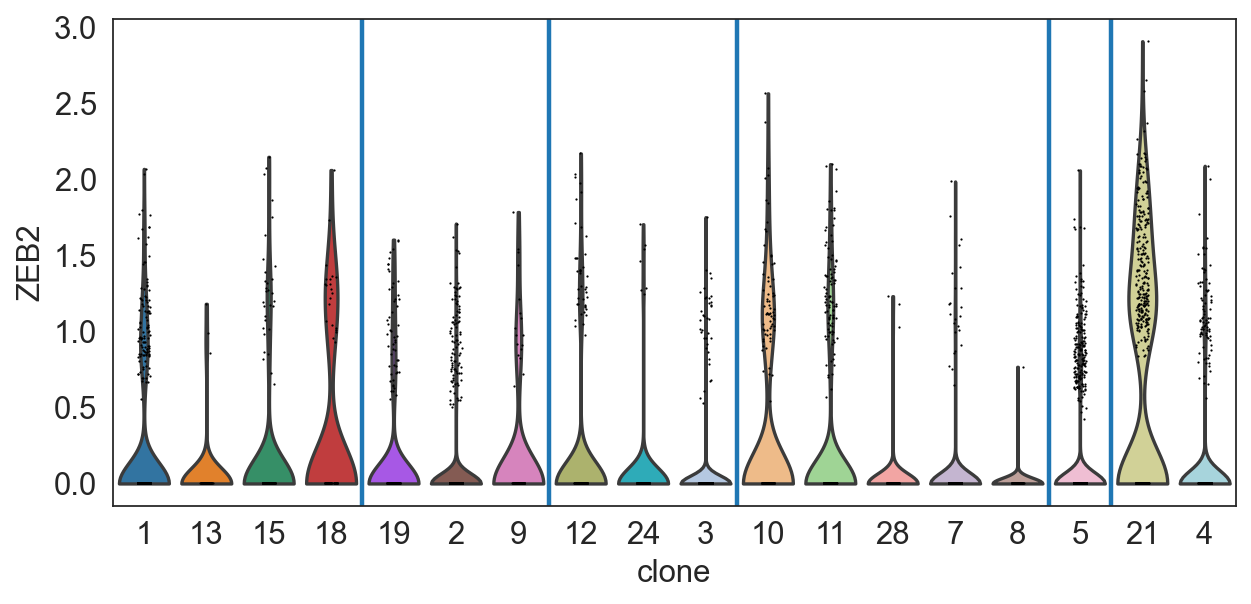

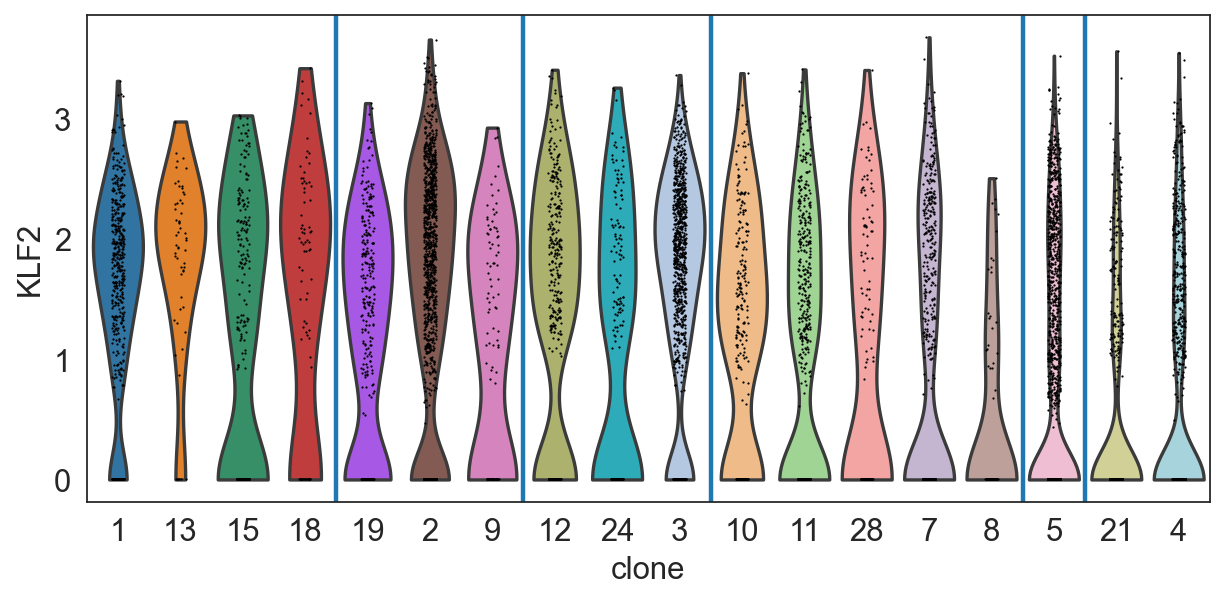

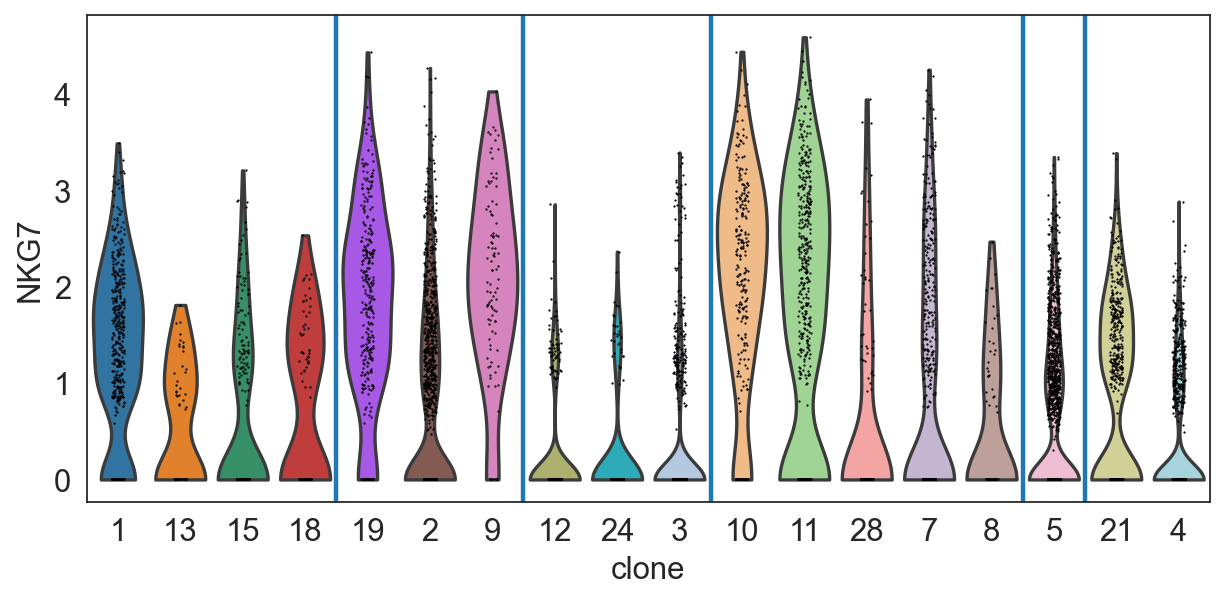

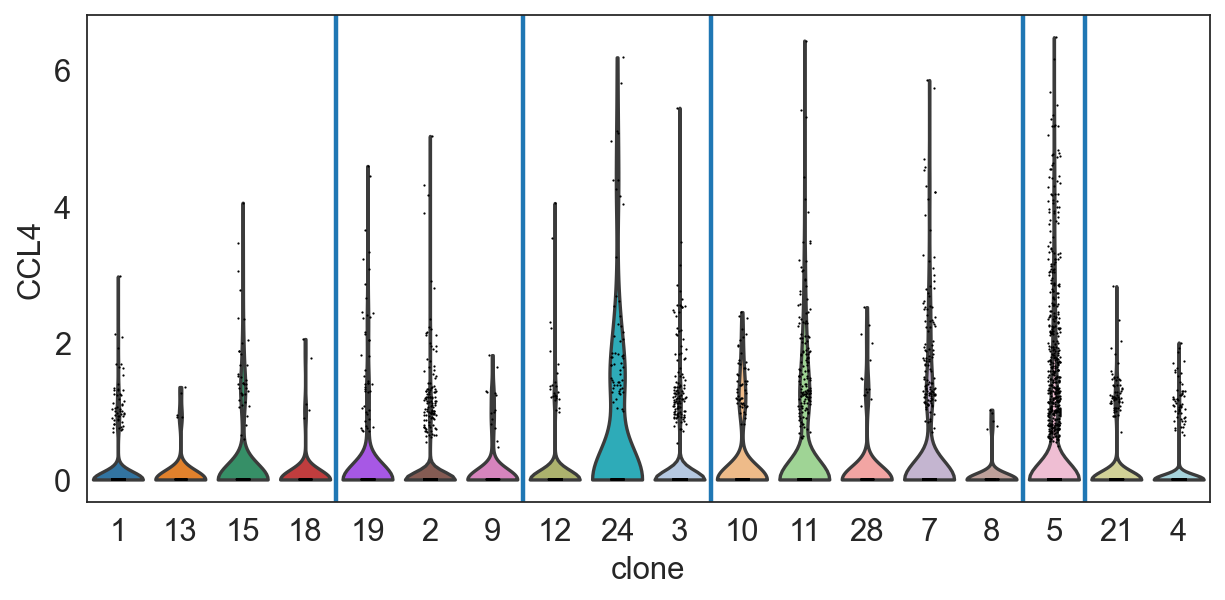

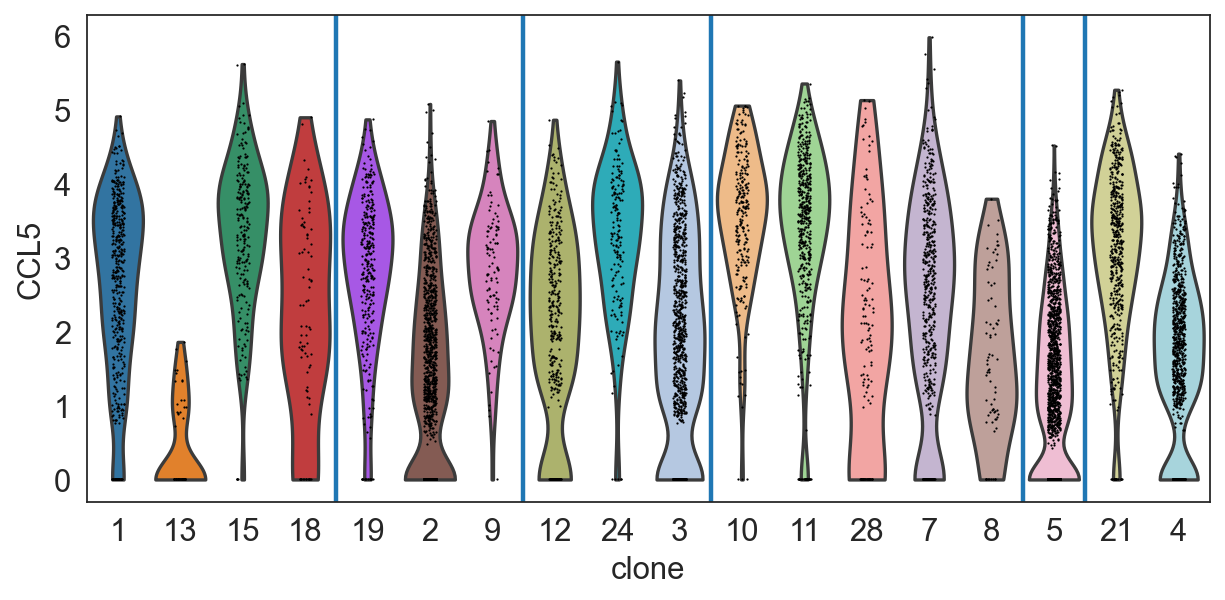

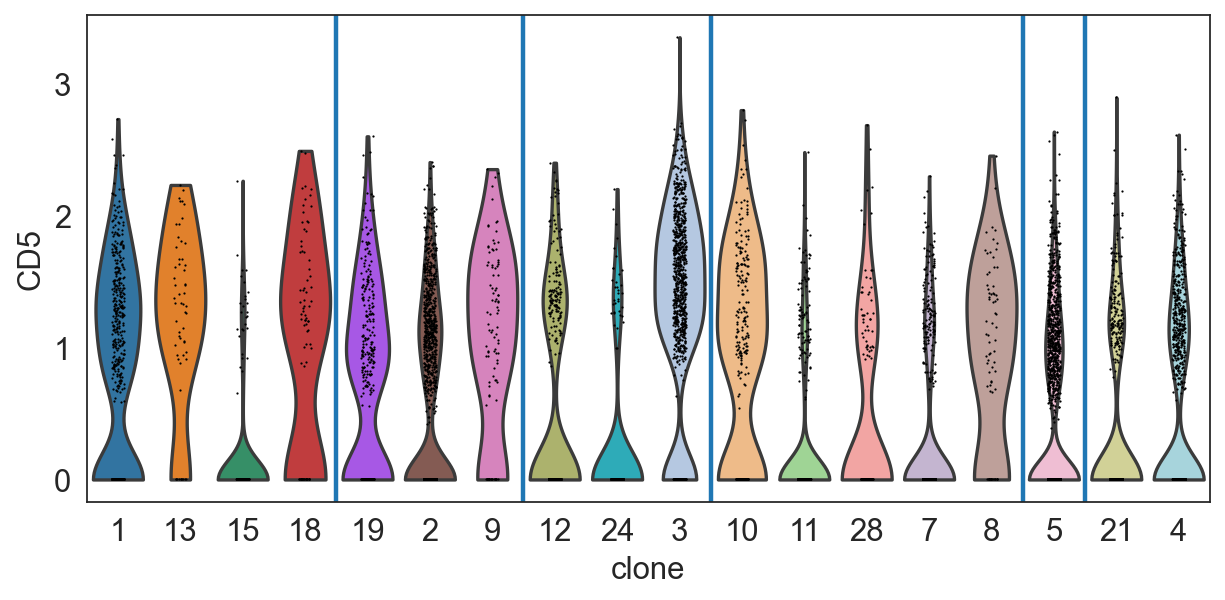

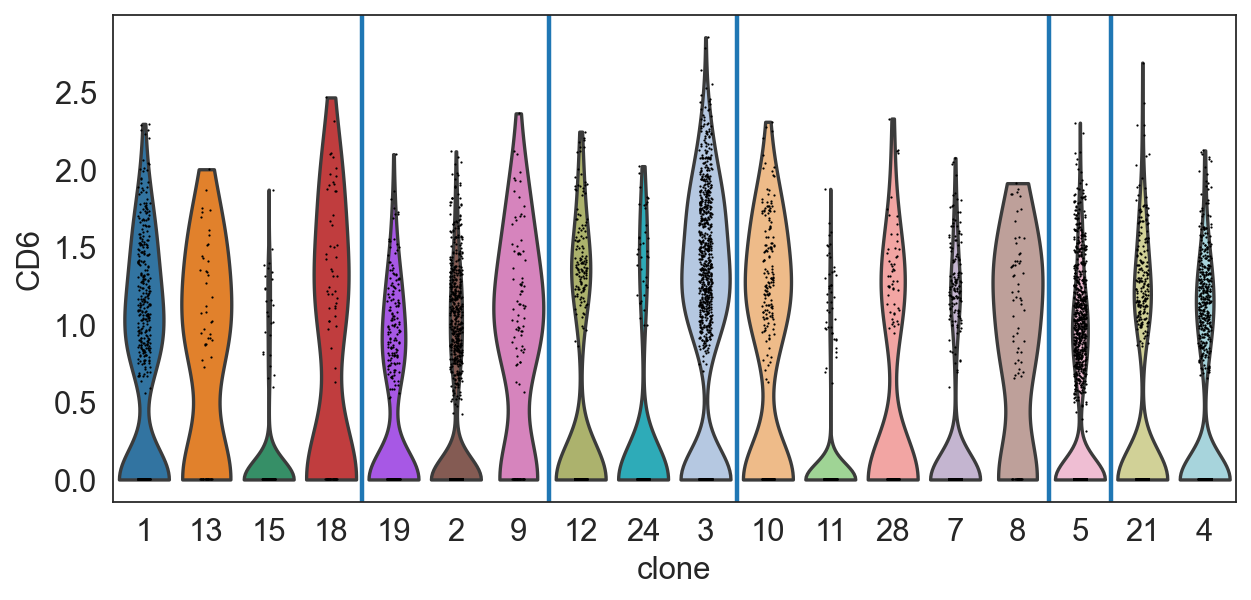

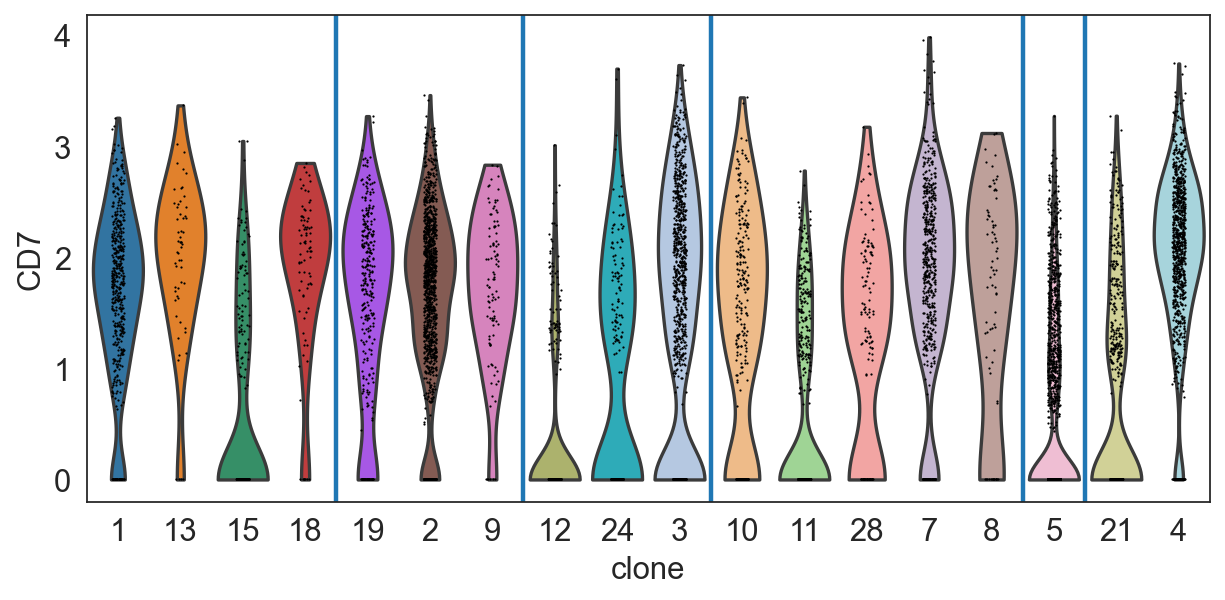

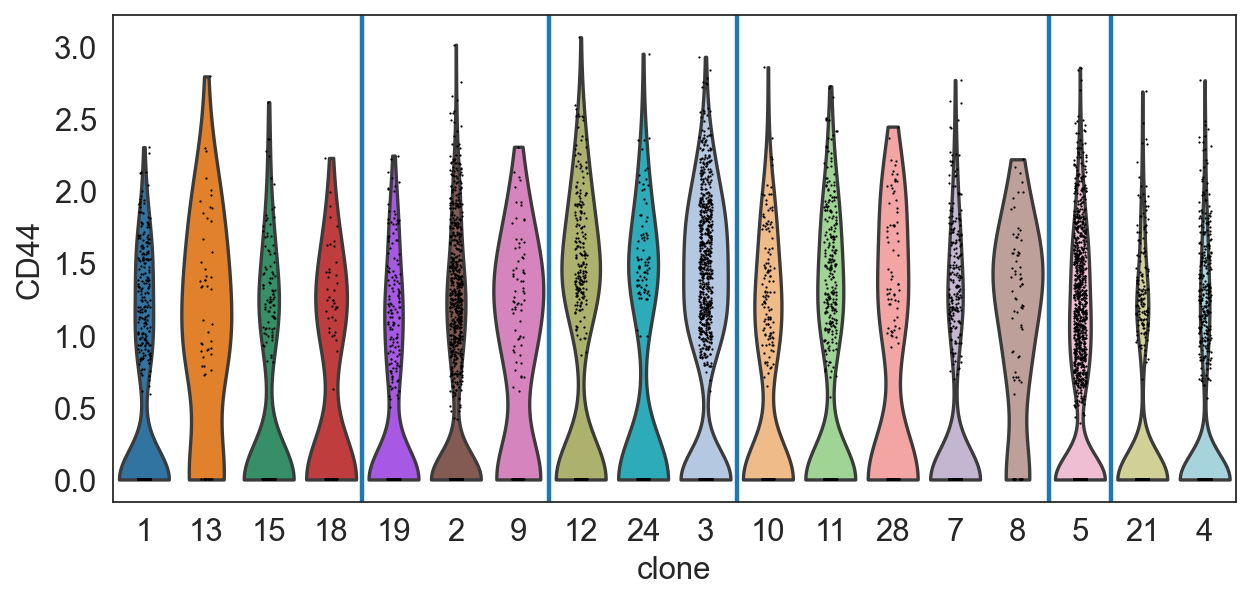

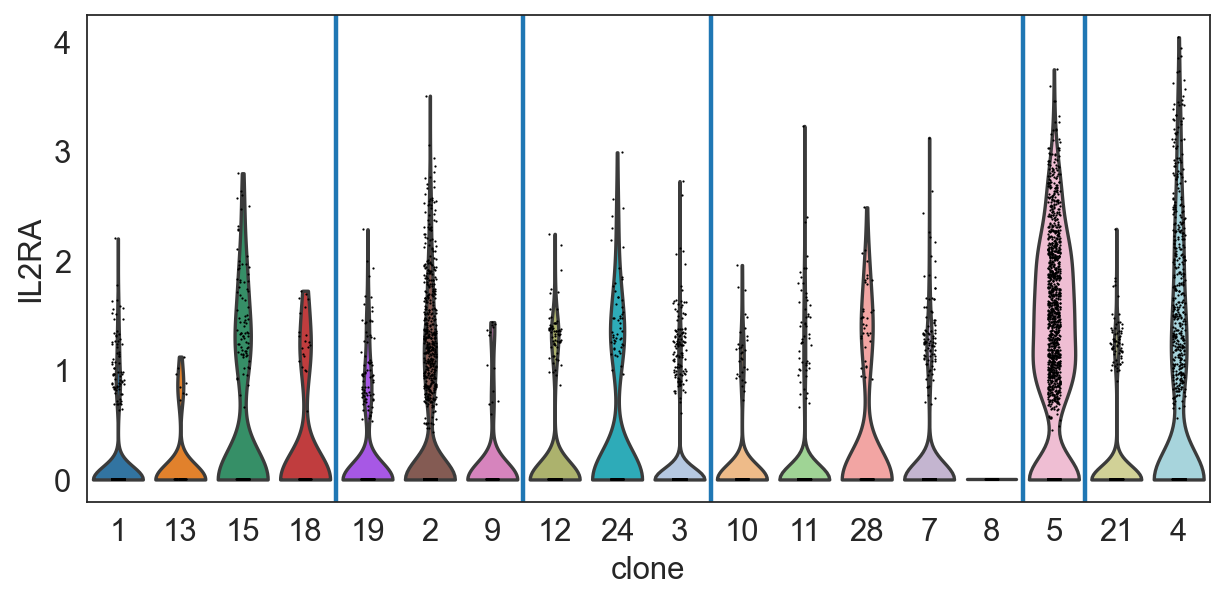

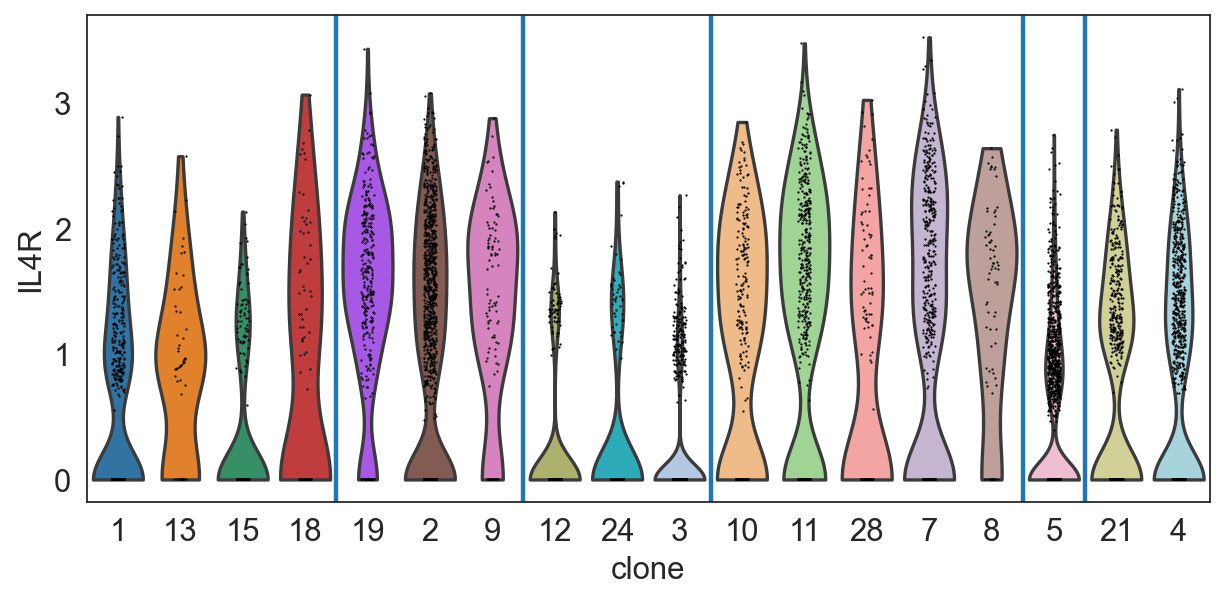

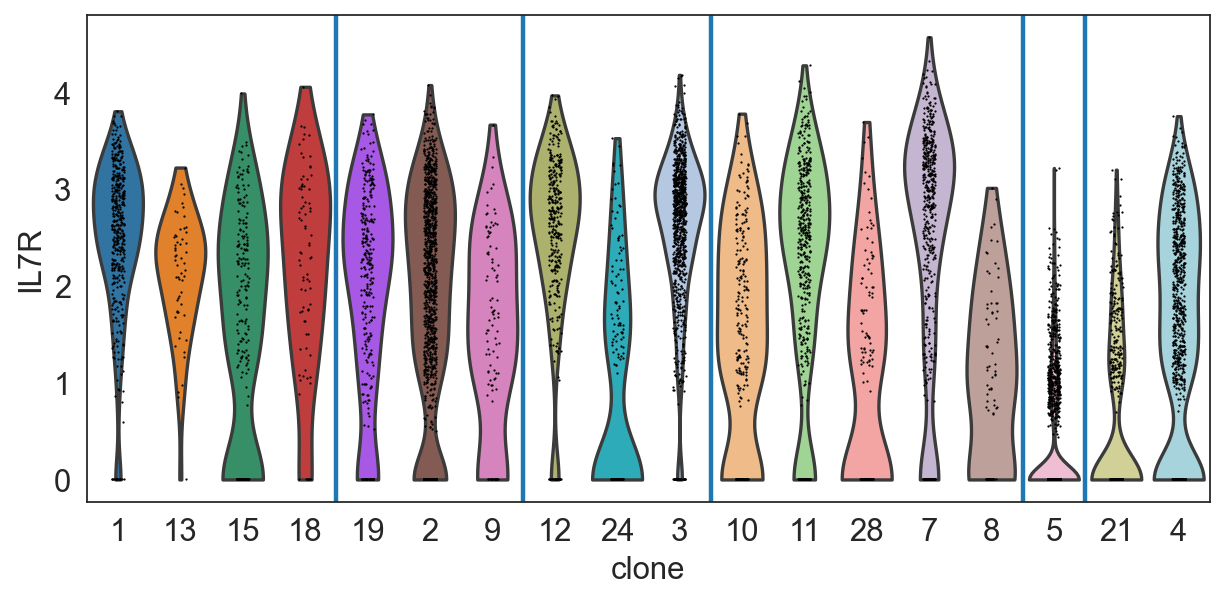

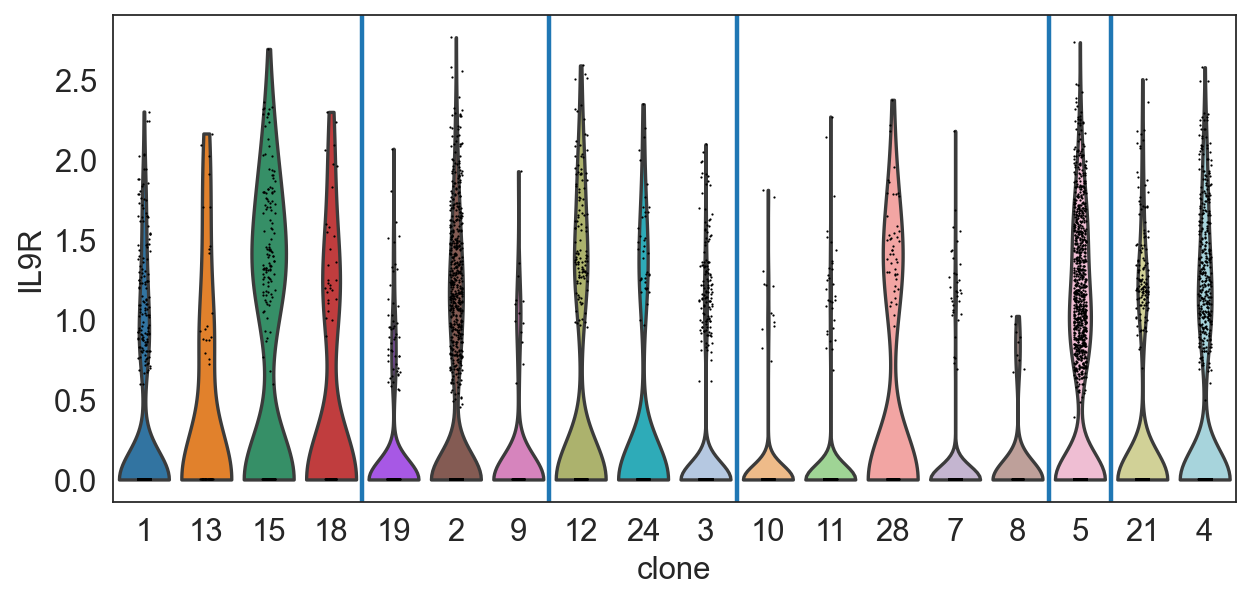

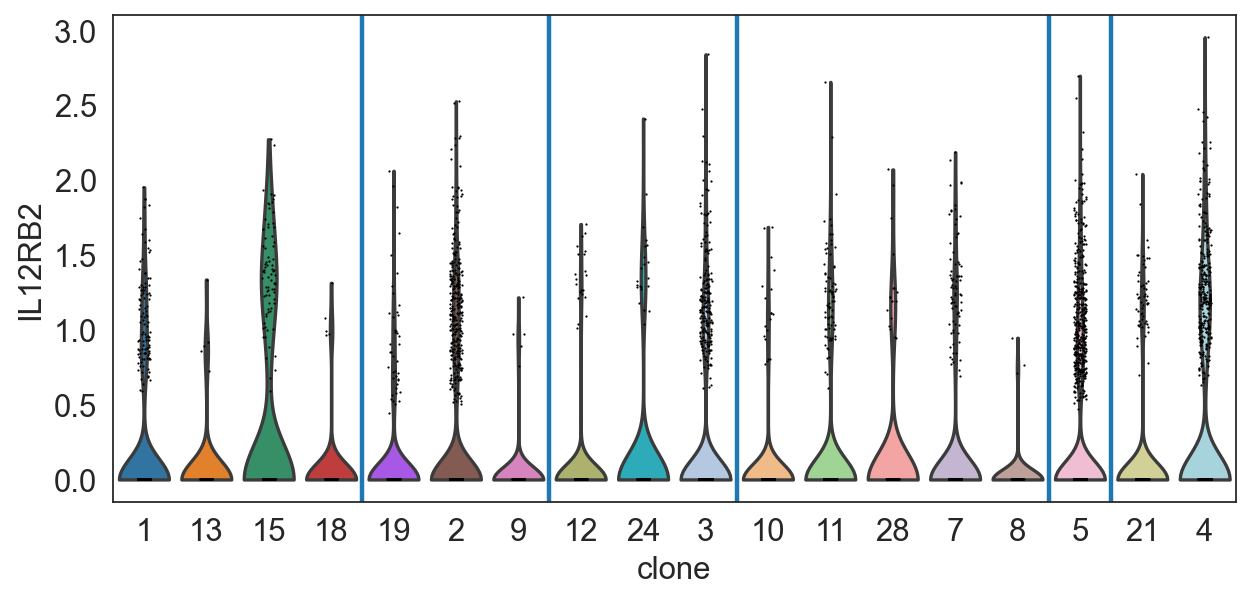

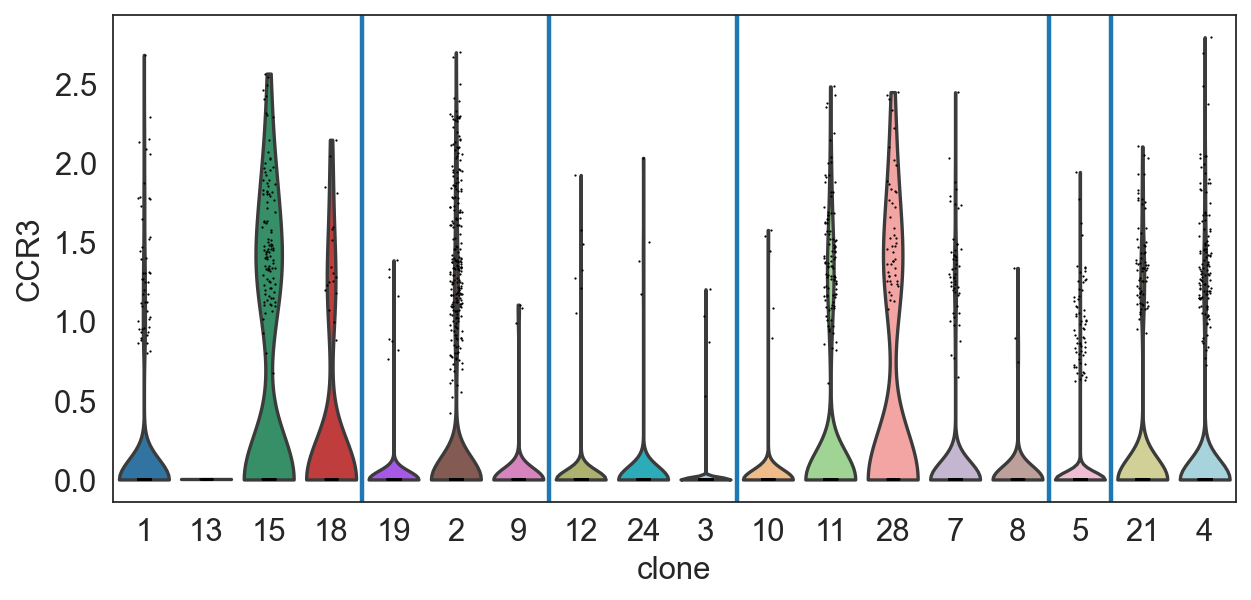

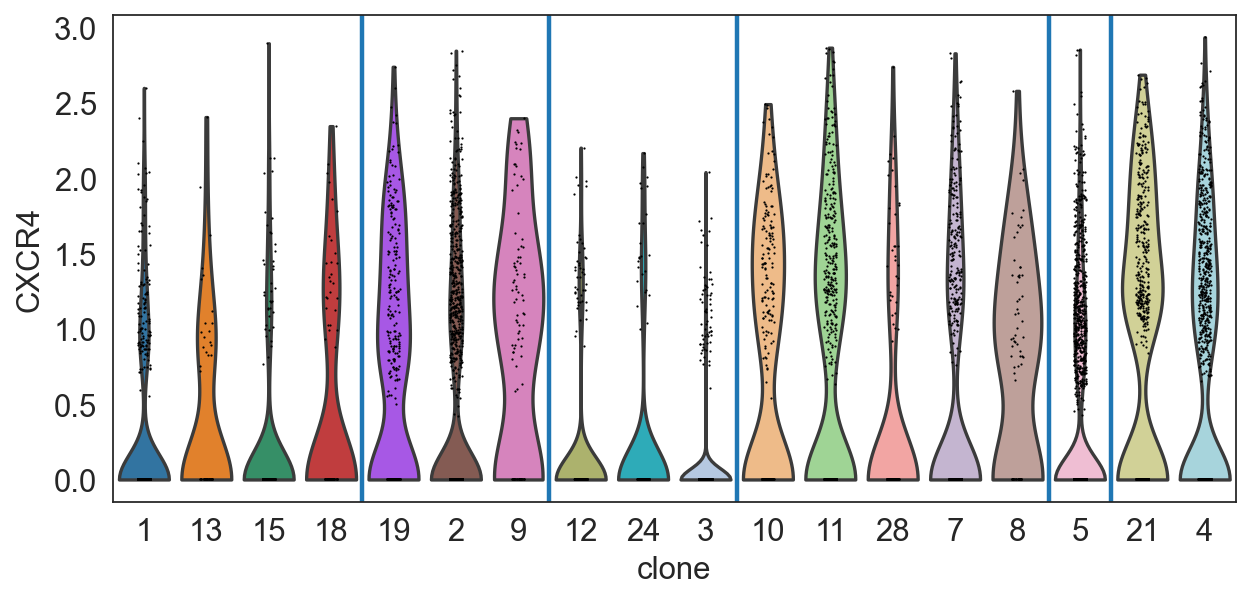

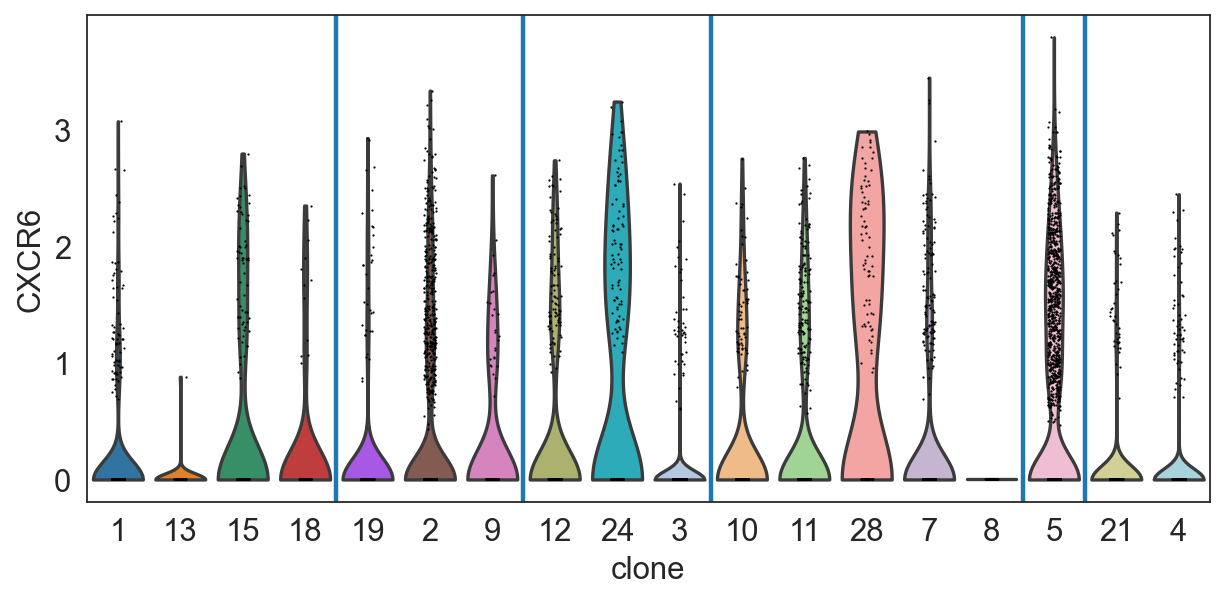

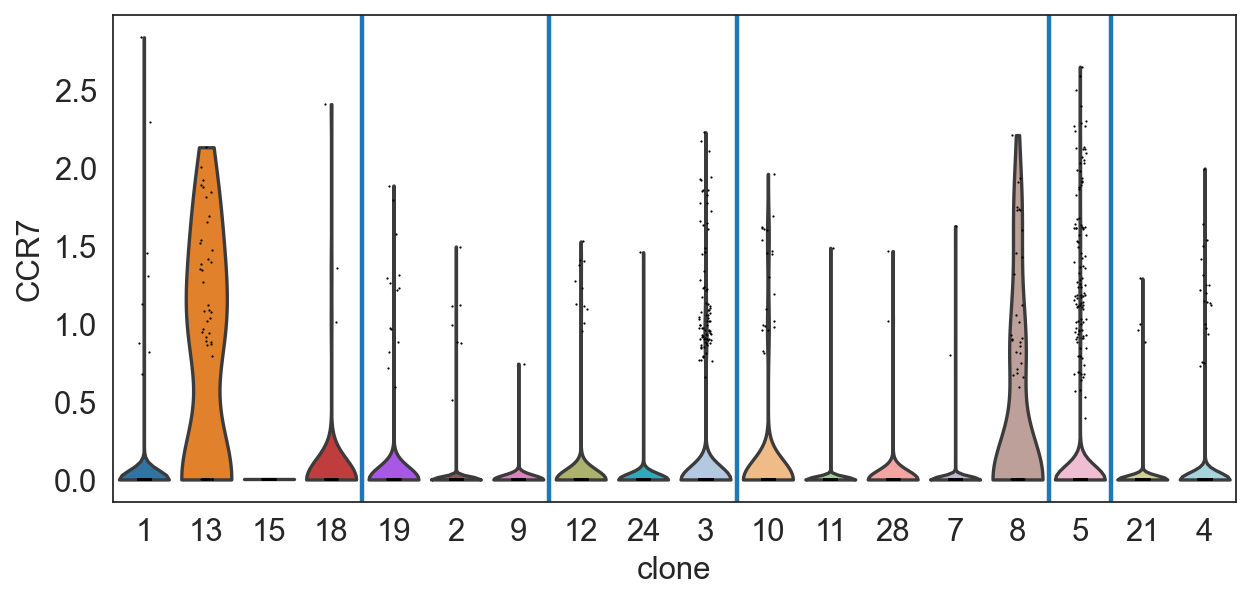

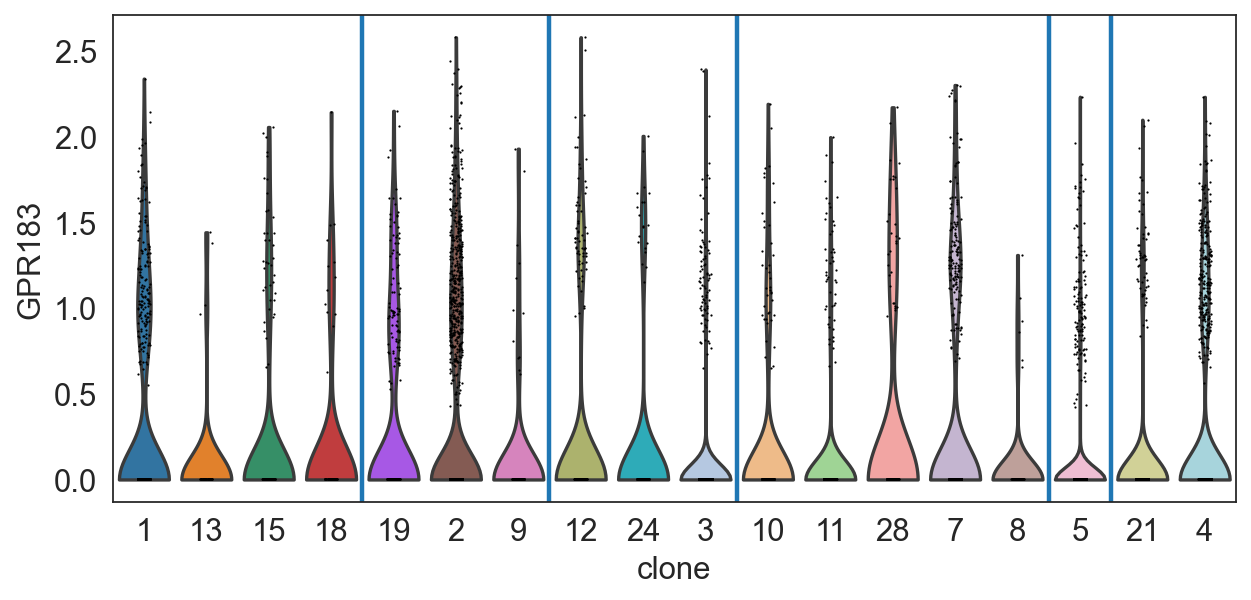

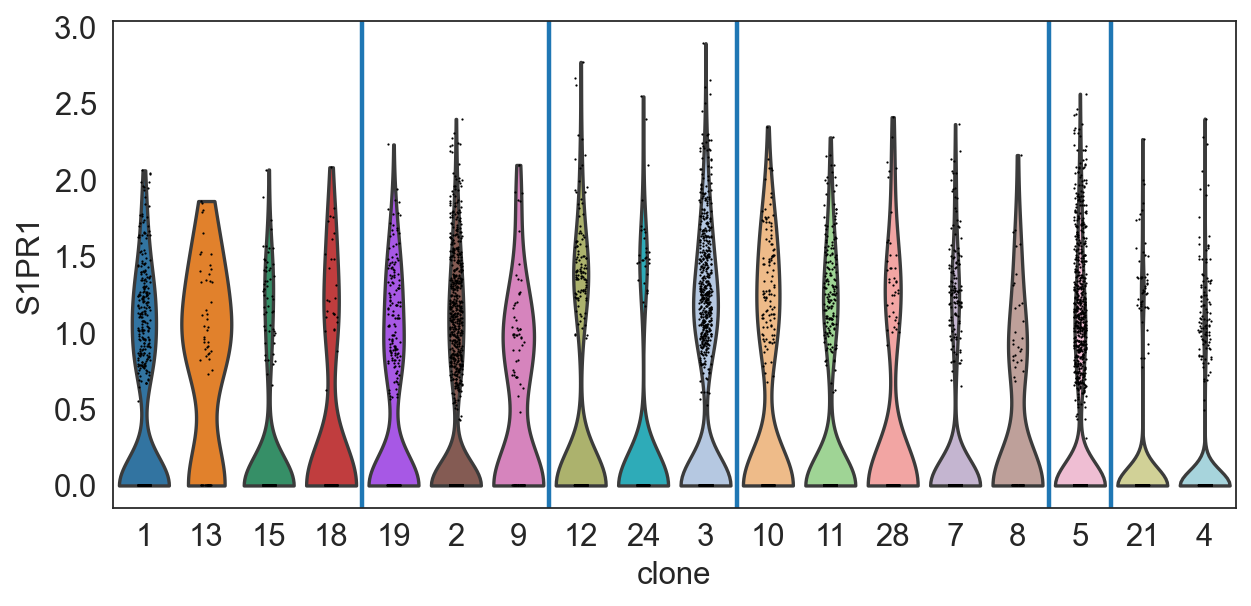

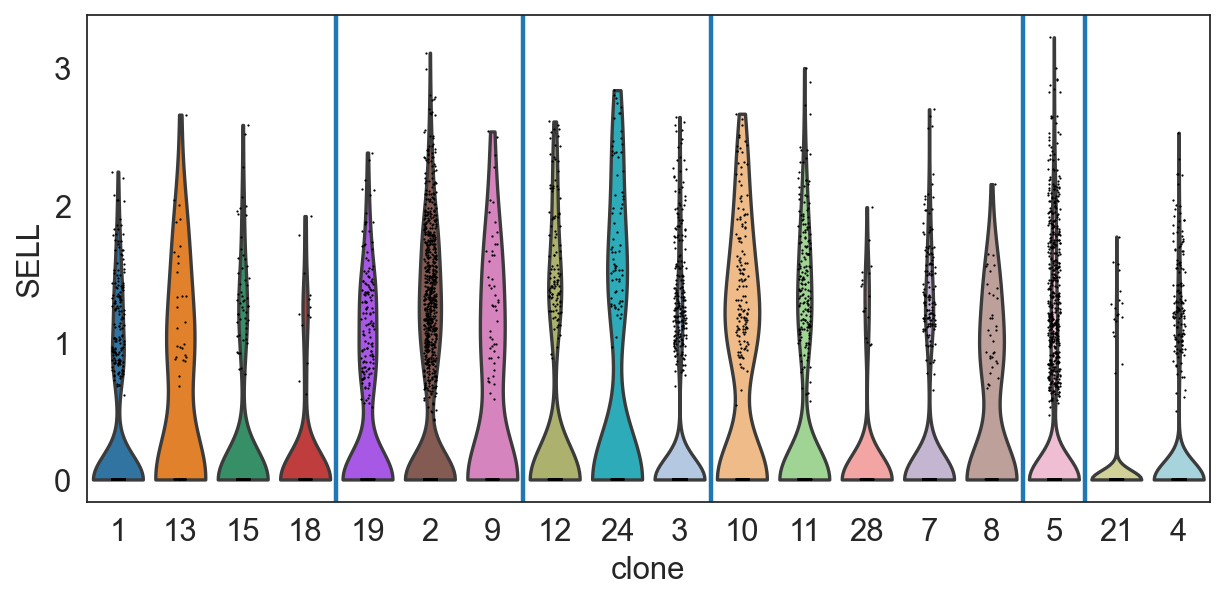

In [125]:
for gene in jeffgenes:
    myvio(gene,'CD4')

# IL2RA and IL7R expression

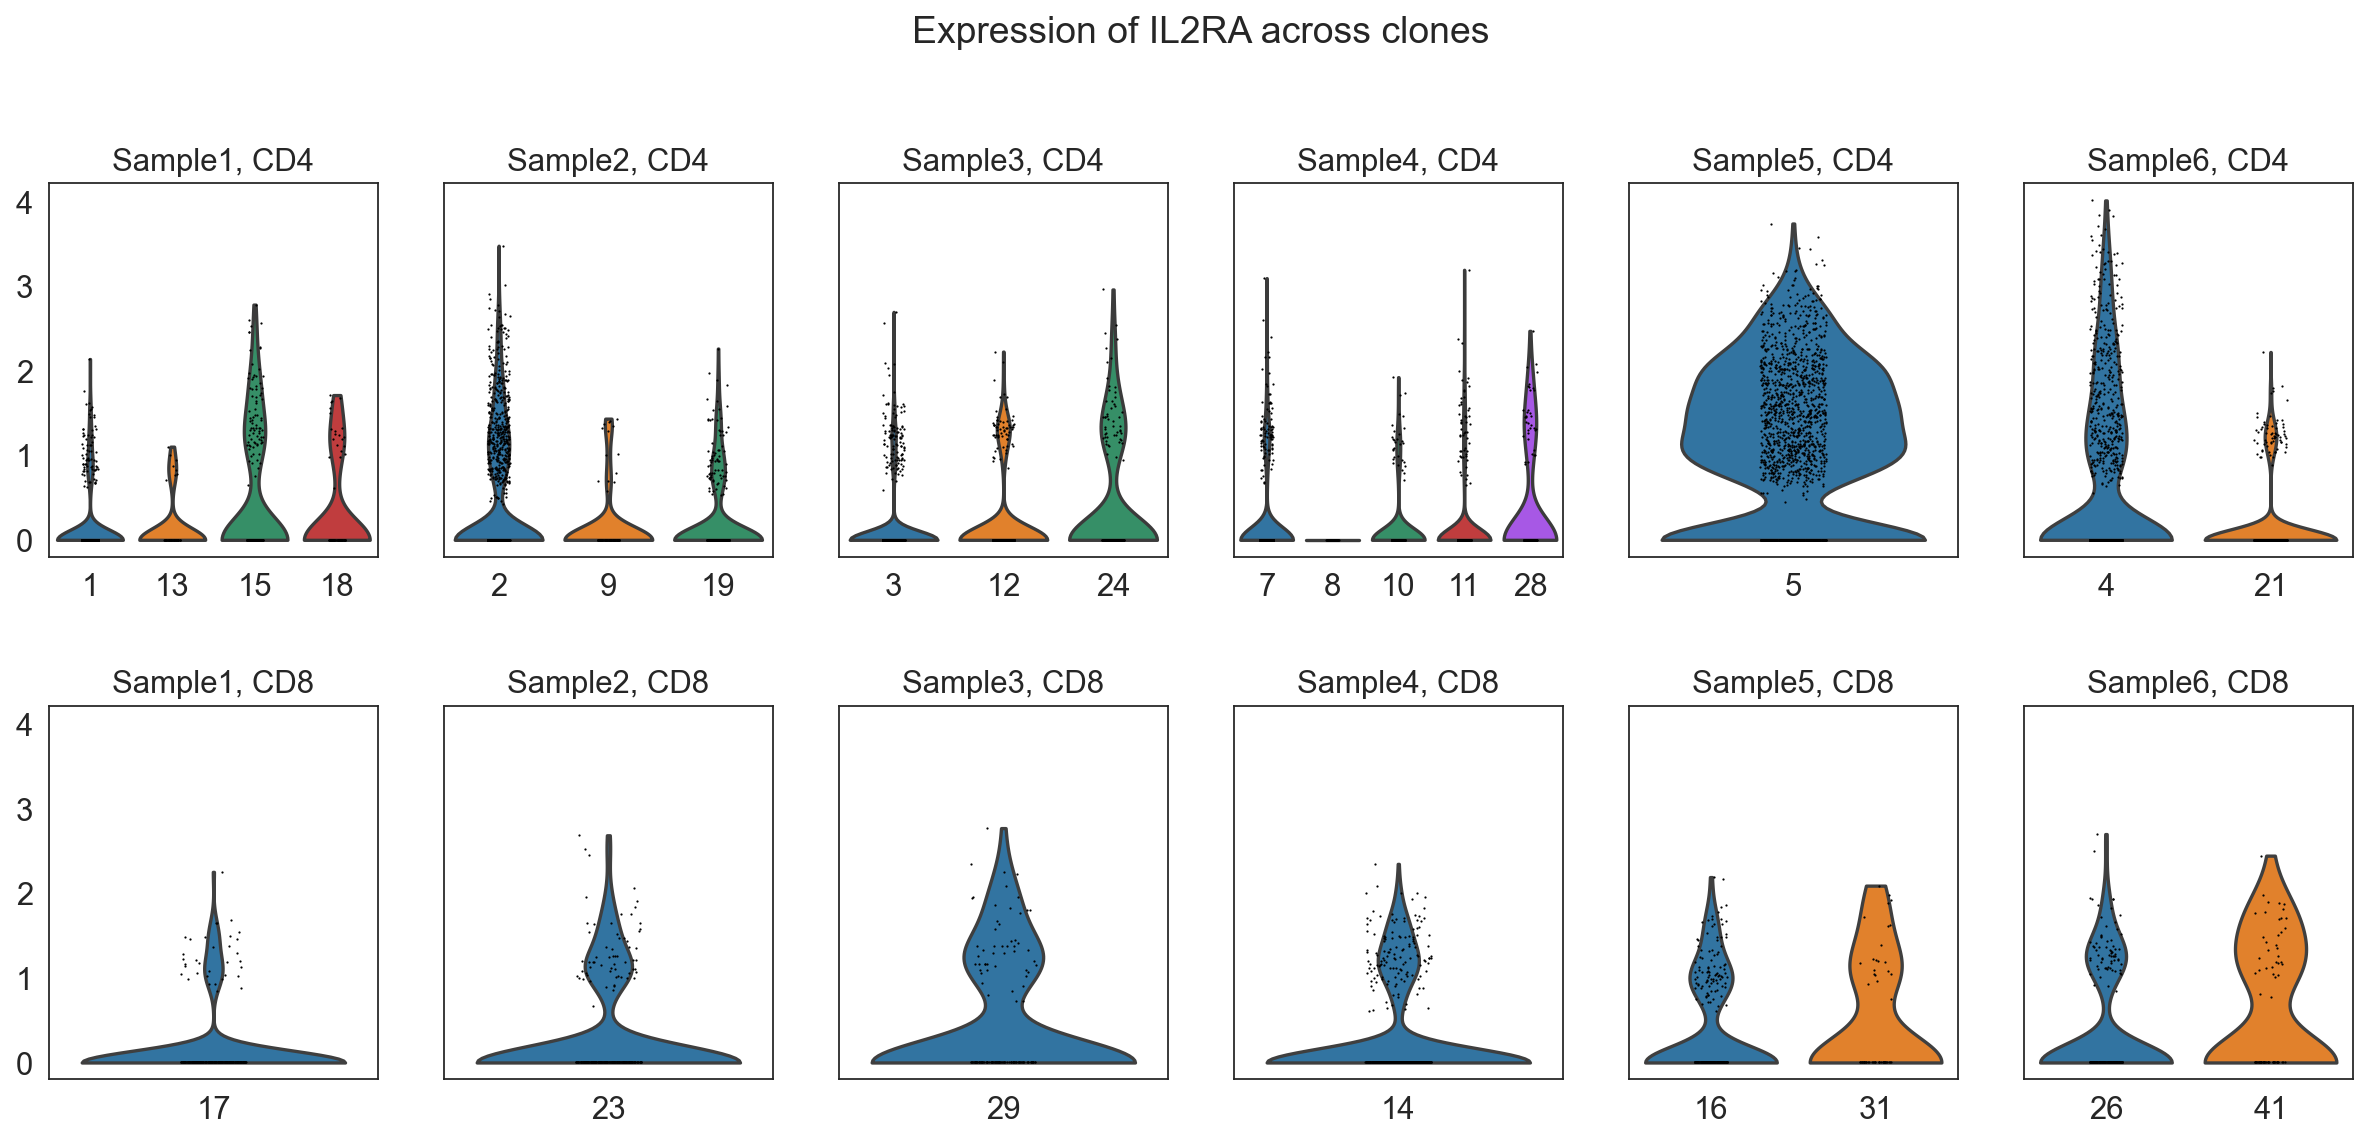

In [126]:
fig,ax = plt.subplots(2,6,figsize=(18,7), sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

for i,cd_type in enumerate(cd_types):
    for j,sample in enumerate(samples):
        ax_now = ax[i,j]
        ds = (sample, cd_type)
        sc.pl.violin(ad[ds], 'IL2RA', groupby='clone', ax=ax_now, show=False)
        ax_now.set_title('{}, {}'.format(sample,cd_type))
        ax_now.set_xlabel('')
        ax_now.set_ylabel('')
        
plt.suptitle('Expression of IL2RA across clones', y=1.05)
plt.show()
    

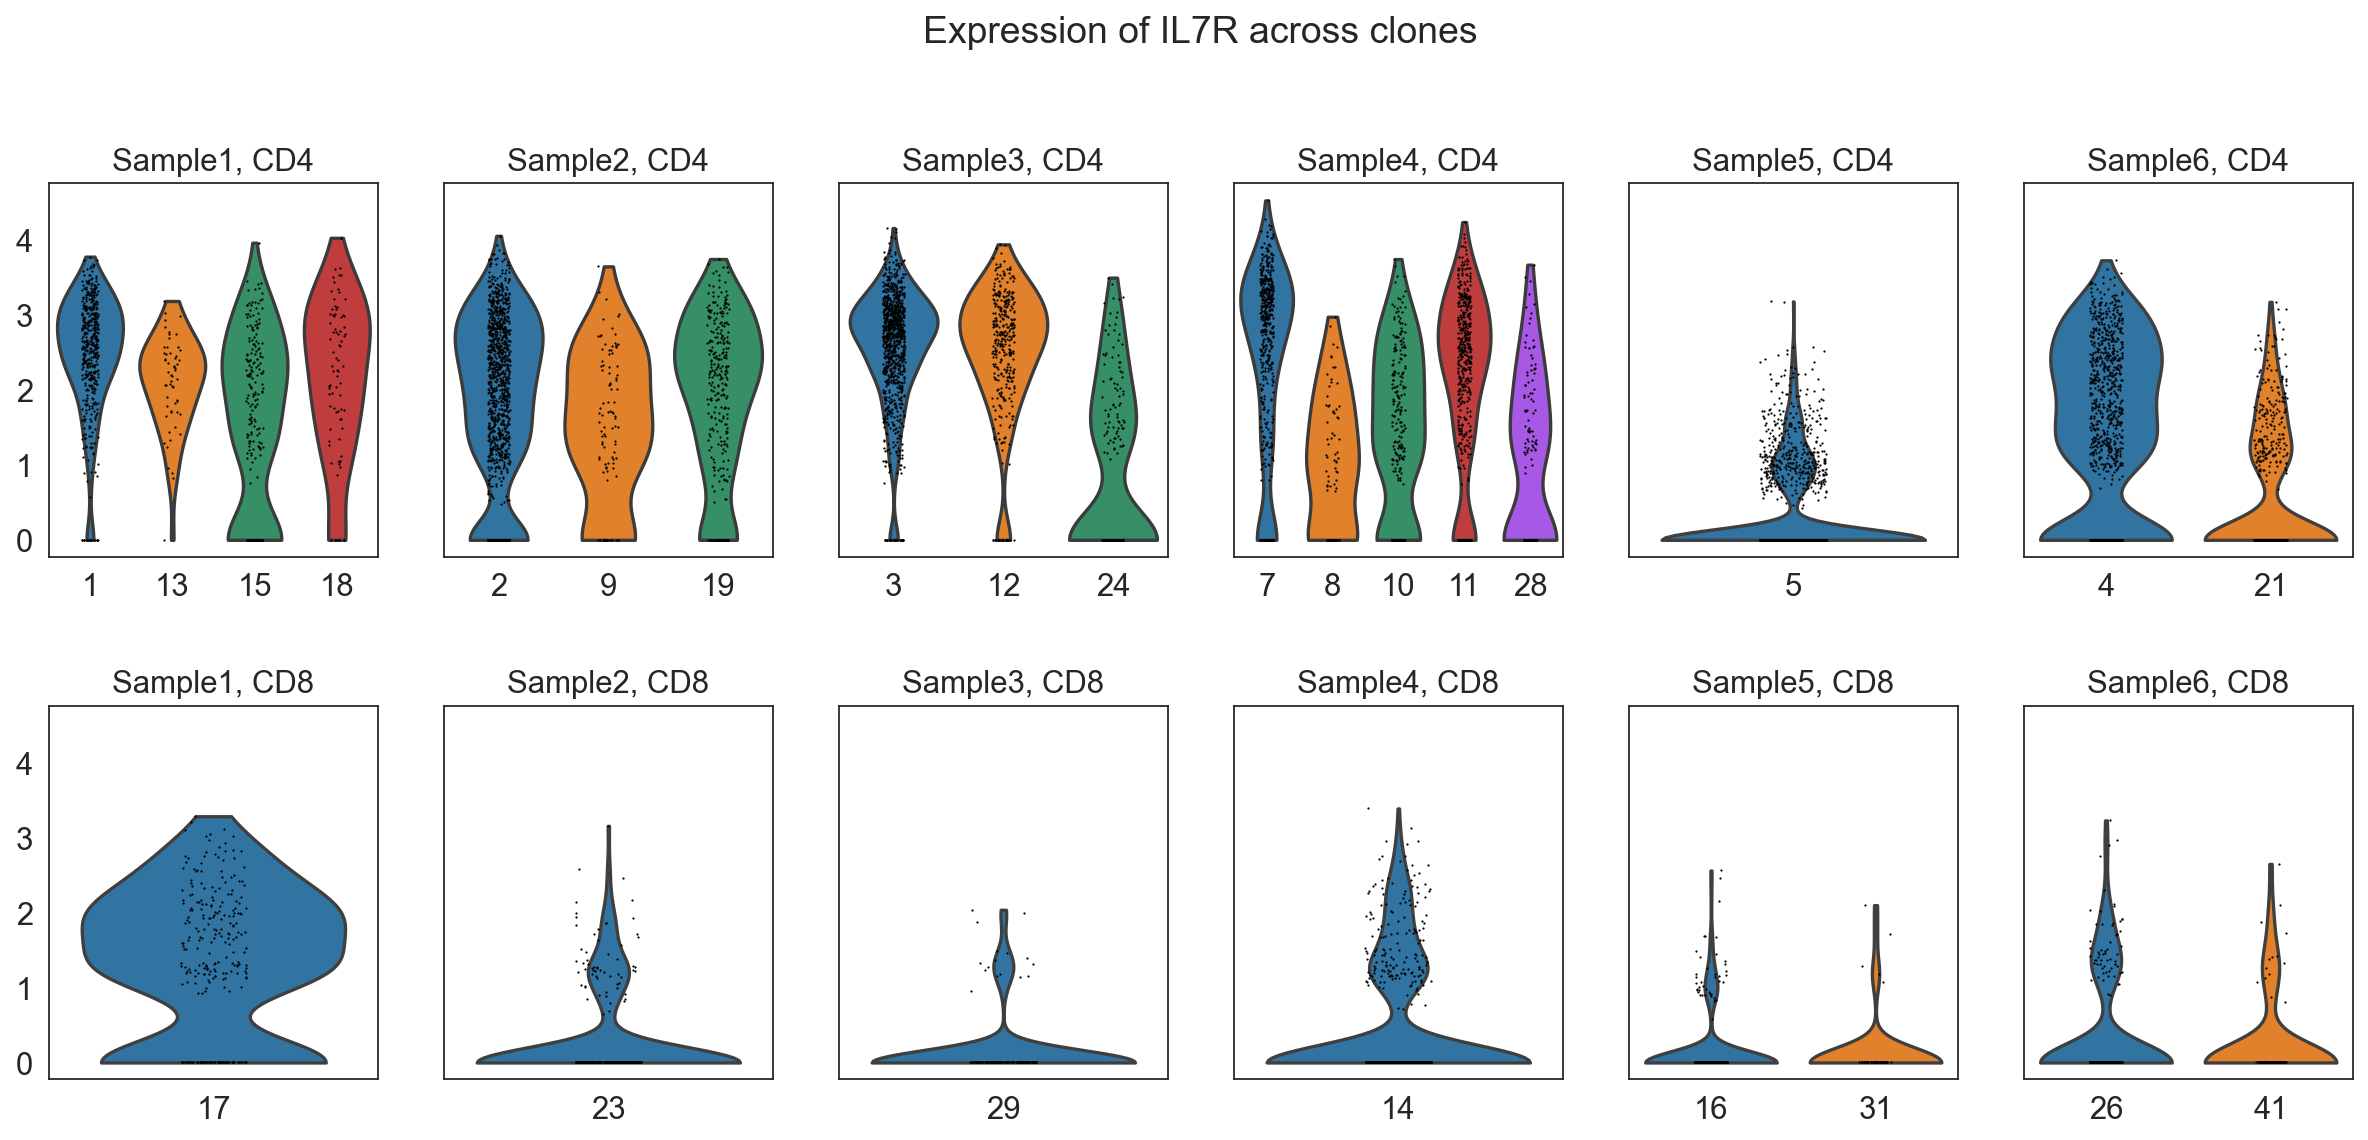

In [127]:
fig,ax = plt.subplots(2,6,figsize=(18,7), sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

for i,cd_type in enumerate(cd_types):
    for j,sample in enumerate(samples):
        ax_now = ax[i,j]
        ds = (sample, cd_type)
        sc.pl.violin(ad[ds], 'IL7R', groupby='clone', ax=ax_now, show=False)
        ax_now.set_title('{}, {}'.format(sample,cd_type))
        ax_now.set_xlabel('')
        ax_now.set_ylabel('')
        
plt.suptitle('Expression of IL7R across clones', y=1.05)
plt.show()

# SVM Clone Signatures in CD4 T-cells

The following function visualizes the results of cross-validation.

In [225]:
def CV_map(gs, swap=False, savefig=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))
    if savefig:
        plt.savefig('CV_map.svg')

In [283]:
wc = {}
clones = {}
ccuts = {}
for cd in cd_types:
    vc = ad[cd].obs[['well','clone']].value_counts()
    wc[cd] = vc[vc >= 100].sort_index().index
    clones[cd] = [mi[1] for mi in wc[cd]]
    ccuts[cd] = pd.Series([mi[0] for mi in wc[cd]]).value_counts().sort_index().cumsum()

In [284]:
clones['CD4']

['1',
 '15',
 '19',
 '2',
 '9',
 '12',
 '24',
 '3',
 '10',
 '11',
 '28',
 '7',
 '5',
 '21',
 '4']

In [285]:
from matplotlib.patches import Rectangle
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi
    
def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False
        
def confusion_matrix(X,y,pipe, reps=2, classlist = None, filename=None, test_size = 0.2):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    valid_dec = np.round(valid*100).astype(int)
    
    figsize=(3.1, len(classlist) / 3.0)
    f, ax = plt.subplots(figsize=figsize, dpi=150)
    #setfontsize()
    #fmt="2.0%"
    sns.heatmap(valid, annot=valid_dec, annot_kws={'fontsize':5}, fmt="d", square=True, linewidths=.25, cbar=None,
                cbar_kws={'fraction':0.02, 'pad':0.02}, ax=ax)
    #cbar = ax.collections[0].colorbar
    #cbar.set_ticks([0, .25, .5, .75, 1])
    #cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    tiks = [t+0.5 for t in range(len(classlist))]
    ax.set_xticks(tiks)
    ax.set_yticks(tiks)
    ax.set_xticklabels(classlist, fontsize=6)
    ax.set_yticklabels(classlist, fontsize=6)
    
    tickypos = -0.3
    pal = sns.color_palette()
    lut = dict(zip(classes, pal))
    for j,cl in enumerate(classes):
        ax.add_patch(Rectangle((tickypos,j+0.1),0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,tickypos),0.8,0.3, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((len(classes)-tickypos,j+0.1),-0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,len(classes)-tickypos),0.8,-0.3, color=lut[cl],fill=True,clip_on=False))
        
    for ccut in ccuts['CD4']:
        ax.axhline(ccut, color='steelblue', xmin=-0.1, xmax=1.1)
        ax.axvline(ccut, color='steelblue')
        
    ax.set_ylabel("Actual clone")
    ax.set_xlabel("Predicted clone")
    ax.set_title("Predicted clonality (%).".format(correct / total))
    
    if filename:
        set_size(f, figsize)
        plt.savefig(filename, bbox_inches='tight')
    # "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [286]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [287]:
inbigs = ad['CD4'].obs.clone.isin(clones['CD4'])
X_cells = inbigs[inbigs].index
X = ad['CD4'].to_df().loc[X_cells]
y = ad['CD4'].obs.clone[X_cells]

In [288]:
y.value_counts()

5     1527
2     1180
3      988
4      908
7      542
21     520
11     482
1      477
12     357
19     309
10     241
15     222
24     174
28     127
9      100
Name: clone, dtype: int64

In [289]:
def downsample(X,y, size=None):
    yvc = y.value_counts()
    minsize = yvc.min()
    if size:
        if size > minsize:
            raise ValueError('size must be less than smallest group size to downsample.')
            return None
        else:
            size = size
    else:
        size = minsize
    num_gps = len(yvc)
    cells = []
    for gp in yvc.index:
        y_gp = y[y == gp]
        cells.append(np.random.choice(y_gp.index, size, replace=False))
    cells = [cell for cell_gp in cells for cell in cell_gp]
    return X.loc[cells], y[cells]
        

In [290]:
X_d, y_d = downsample(X,y)

In [291]:
from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 

In [292]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=100)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = [10,50,100,200,300,400], 
                  svm__C = [0.01,0.1, 1.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X_d,y_d)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=100)),
                                       ('svm',
                                        LinearSVC(max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [10, 50, 100, 200, 300, 400],
                         'svm__C': [0.01, 0.1, 1.0]})

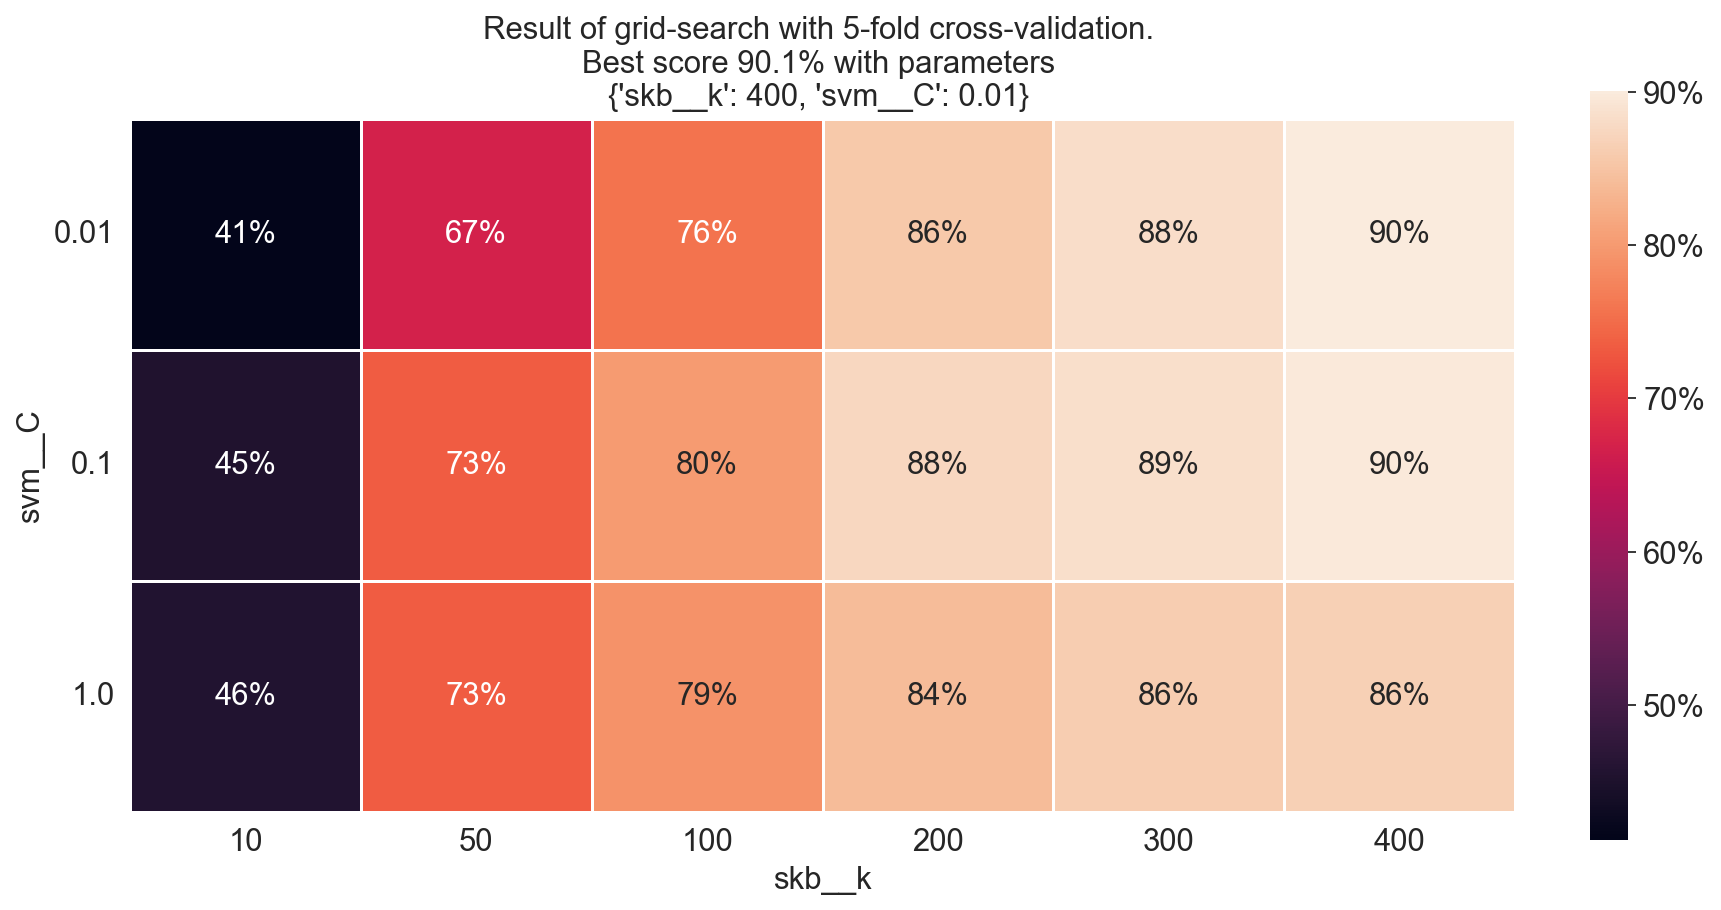

In [293]:
CV_map(grid_search, swap=True)

In [294]:
classlist = clones['CD4']

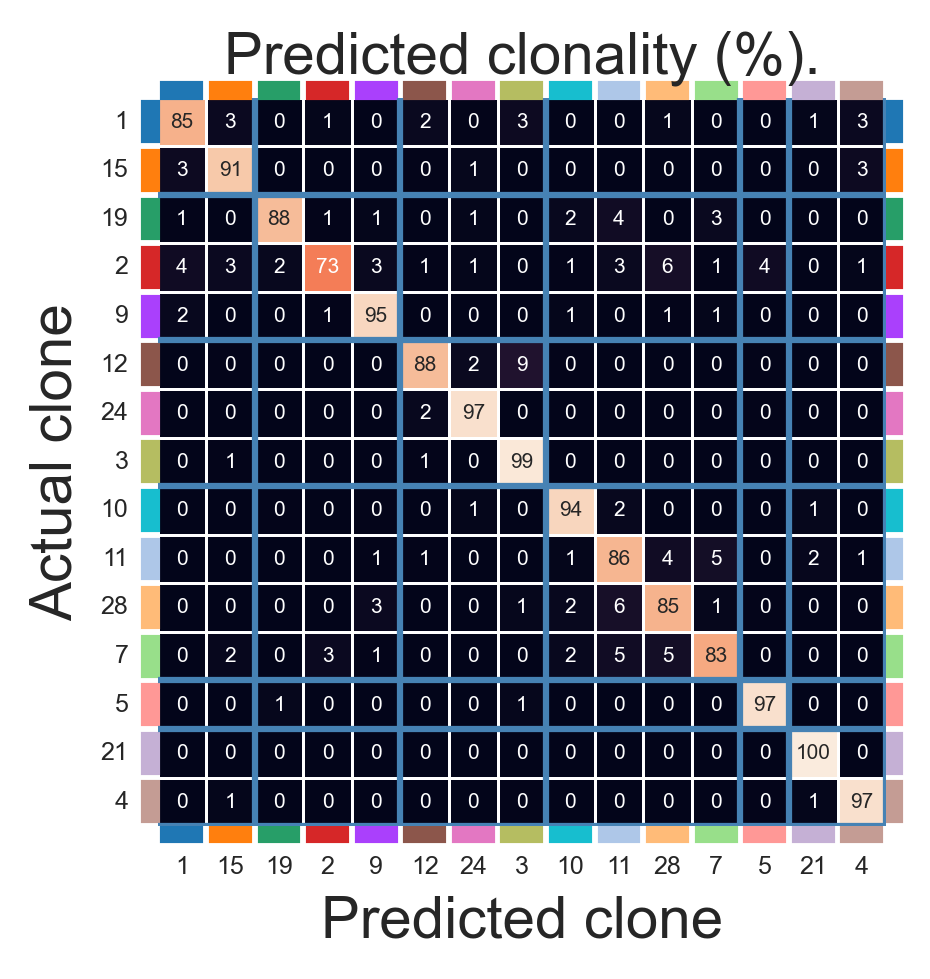

In [295]:
opt_k = grid_search.best_params_['skb__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['svm__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

confusion_matrix(X_d,y_d,SVMpipe, reps=10, classlist = classlist, filename='SVM_confusion_CD4.pdf')

In [274]:
opt_k

400

In [275]:
y.value_counts()

5     1527
2     1180
3      988
4      908
7      542
21     520
11     482
1      477
12     357
19     309
10     241
15     222
Name: clone, dtype: int64